In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
res = 24

In [3]:
# Count training and validation samples
training_N = 0
valid_N = 0
for file in os.listdir("training/"):
    label = file.split(".")[0].split("_")
    if (label[0][0:2] == "vv"): valid_N += 1
    else: training_N += 1
        
print(training_N)
print(valid_N)

1119
0


In [4]:
# This is just a copy of the simple MNIST tutorial
# https://keras.io/examples/vision/mnist_convnet/
model_terrain = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(8, activation="softmax"),
    ]
)

model_crowns = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)


In [5]:
training_N += valid_N
noise_loops = 1

training_x= np.zeros((4*noise_loops*training_N, res, res, 3))
terrain_y = np.zeros(4*noise_loops*training_N)
crowns_y = np.zeros(4*noise_loops*training_N)

valid_x = np.zeros((valid_N, res, res, 3))
valid_terrain_y = np.zeros(valid_N)
valid_crowns_y = np.zeros(valid_N)

cntT = 0
cntV = 0
for file in os.listdir("training/"):
    tile = cv2.cvtColor(cv2.imread("training/" + file), cv2.COLOR_BGR2RGB)
    tile = cv2.resize(tile, (res, res))
    label = file.split(".")[0].split("_")
    
    if label[0][0:2] == "vv":
        valid_x[cntV] = tile
        valid_terrain_y[cntV] = int(label[2])
        valid_crowns_y[cntV] = int(label[3])
        cntV = cntV + 1
    
    for k in range(4):
        training_x[cntT] = tile
        terrain_y[cntT] = int(label[2])
        crowns_y[cntT] = int(label[3])
        cntT = cntT + 1

        for j in range(noise_loops - 1):
            tmp = tile.copy()
            tmp = tmp + np.random.normal(0, 4, tmp.shape)
            training_x[cntT] = tmp
            terrain_y[cntT] = int(label[2])
            crowns_y[cntT] = int(label[3])
            cntT = cntT + 1

        tile = np.rot90(tile)


In [24]:
# randomly assign things to a validation set until I can get a seperate one cooked up
dims = np.arange(training_x.shape[0])
valid_N = 1000
idxs = np.random.choice(dims, valid_N)
valid_x = training_x[idxs]
valid_terrain_y = terrain_y[idxs]
valid_crowns_y = crowns_y[idxs]

In [7]:
model_terrain.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model_crowns.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [8]:
print("Fit model on training data")
history = model_terrain.fit(
    training_x,
    terrain_y,
    batch_size=256,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(valid_x, valid_terrain_y),
)

Fit model on training data
Epoch 1/20
18/18 [==============================] - 1s 40ms/step - loss: 18.5050 - sparse_categorical_accuracy: 0.4015 - val_loss: 1.2258 - val_sparse_categorical_accuracy: 0.5990
Epoch 2/20
18/18 [==============================] - 0s 25ms/step - loss: 1.5508 - sparse_categorical_accuracy: 0.5355 - val_loss: 0.8781 - val_sparse_categorical_accuracy: 0.6770
Epoch 3/20
18/18 [==============================] - 0s 23ms/step - loss: 1.4701 - sparse_categorical_accuracy: 0.5279 - val_loss: 1.2031 - val_sparse_categorical_accuracy: 0.6170
Epoch 4/20
18/18 [==============================] - 0s 24ms/step - loss: 1.4466 - sparse_categorical_accuracy: 0.5362 - val_loss: 0.9321 - val_sparse_categorical_accuracy: 0.7050
Epoch 5/20
18/18 [==============================] - 0s 23ms/step - loss: 1.1690 - sparse_categorical_accuracy: 0.6157 - val_loss: 1.9098 - val_sparse_categorical_accuracy: 0.5890
Epoch 6/20
18/18 [==============================] - 0s 22ms/step - loss: 1.21

In [9]:
score = model_terrain.evaluate(valid_x, valid_terrain_y, verbose=1)

32/32 [==============================] - 0s 2ms/step - loss: 1.9171 - sparse_categorical_accuracy: 0.6860


<ipython-input-10-e1dd83e2cc4e>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


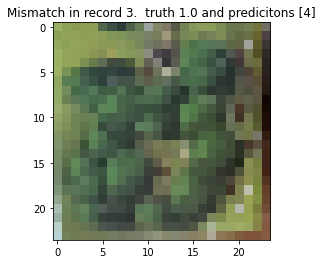

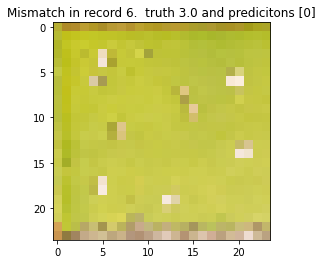

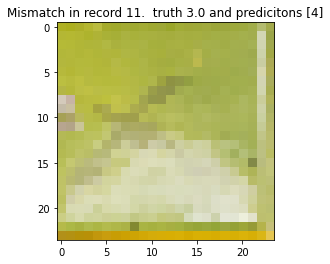

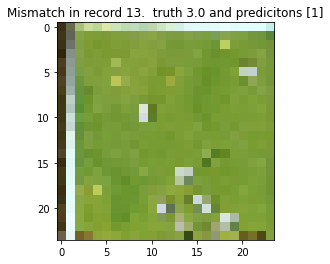

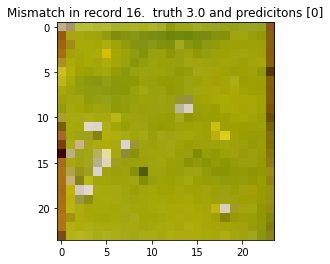

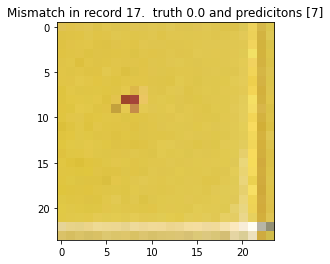

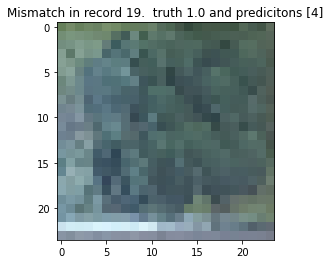

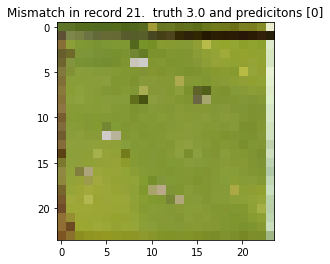

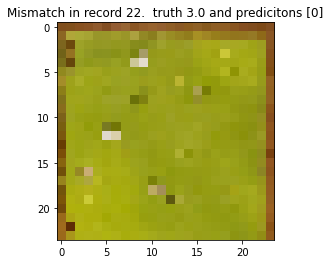

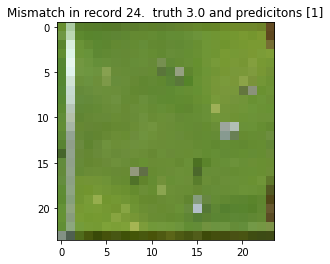

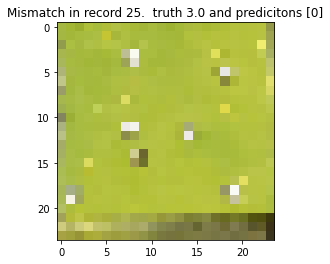

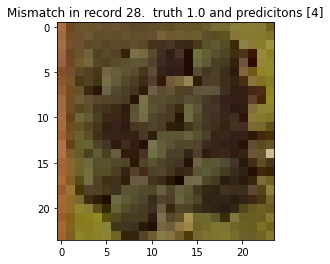

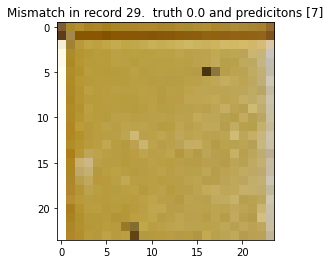

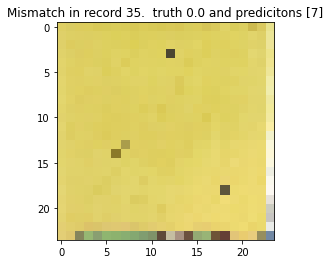

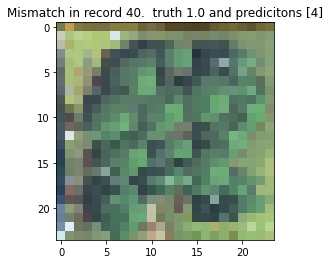

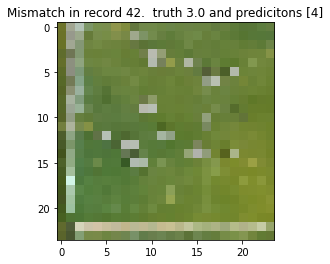

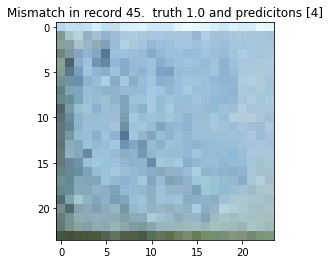

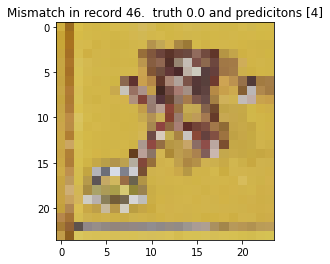

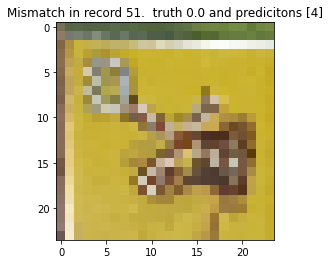

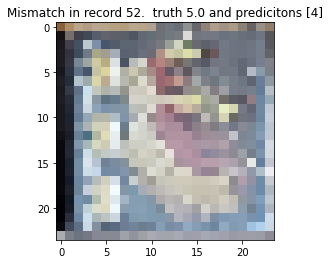

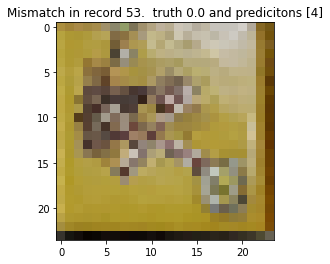

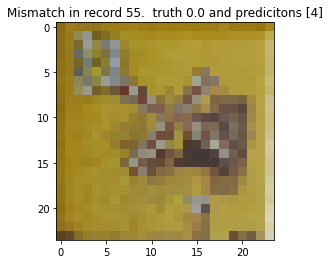

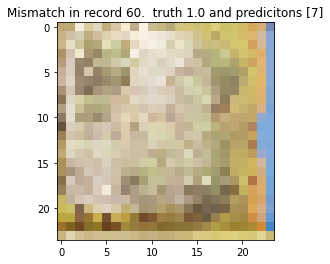

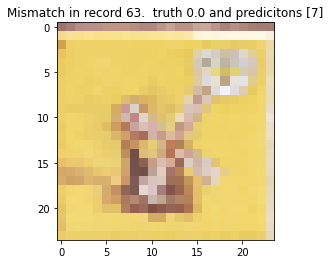

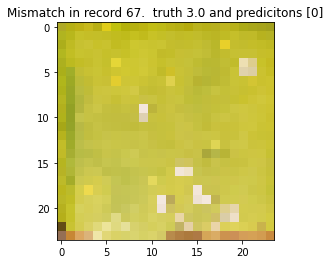

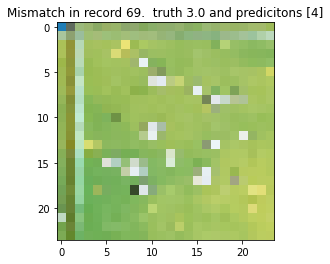

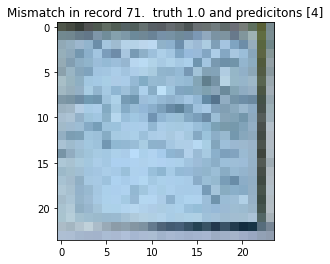

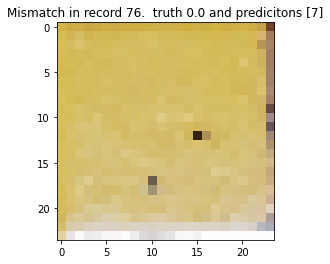

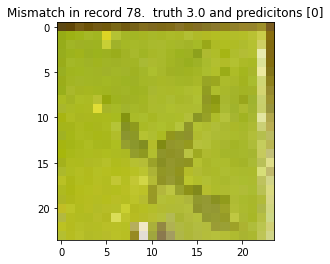

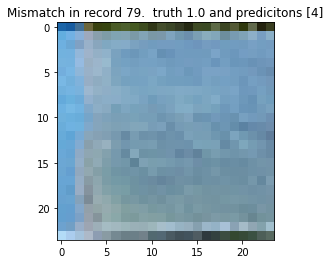

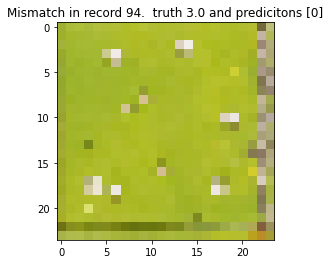

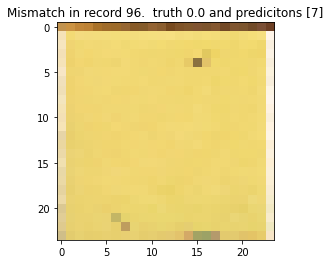

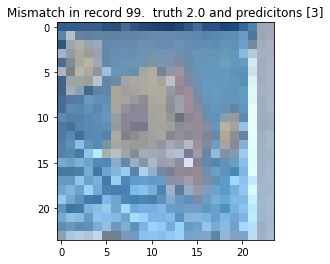

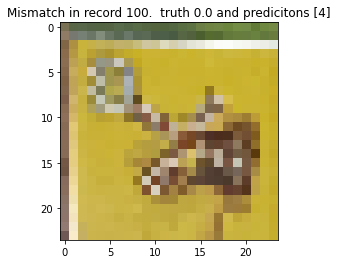

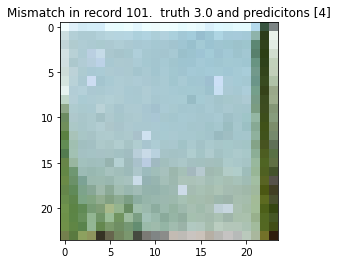

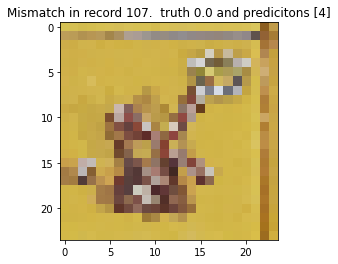

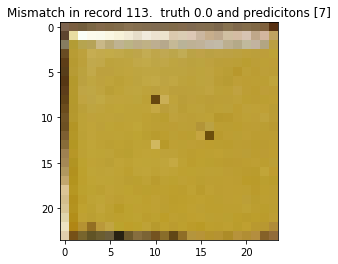

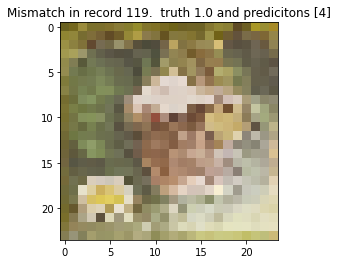

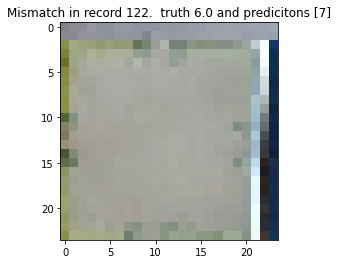

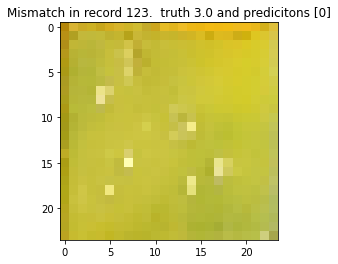

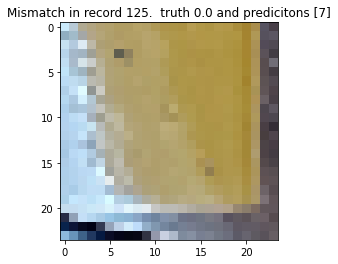

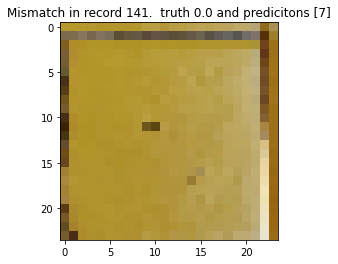

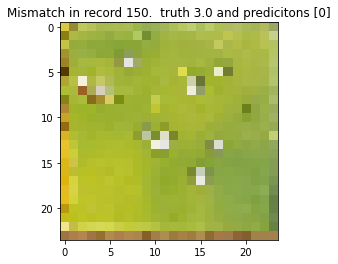

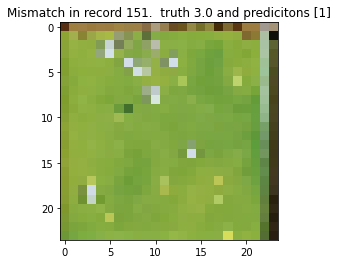

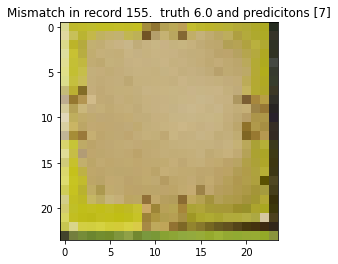

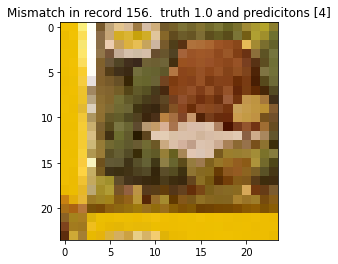

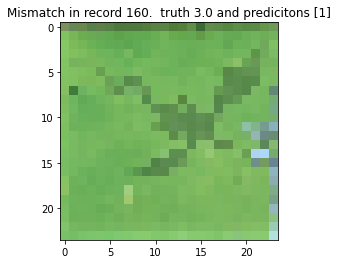

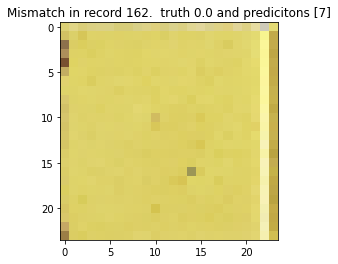

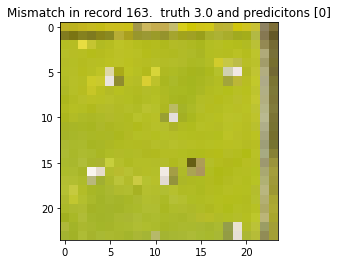

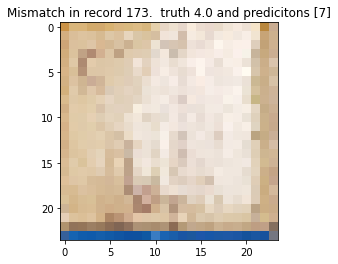

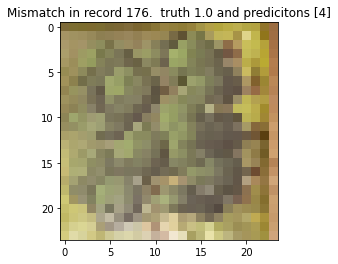

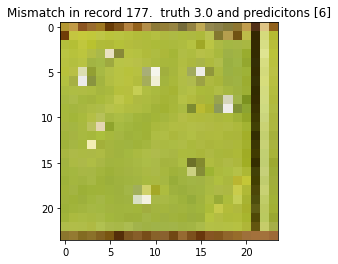

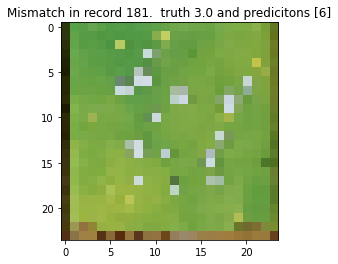

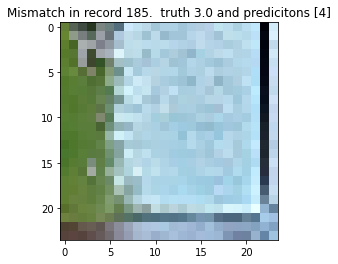

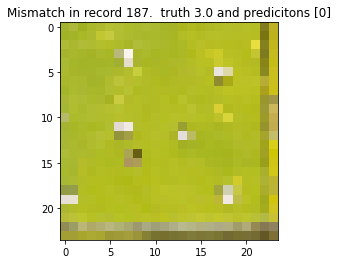

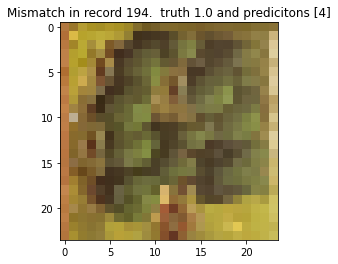

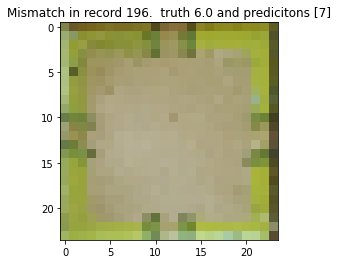

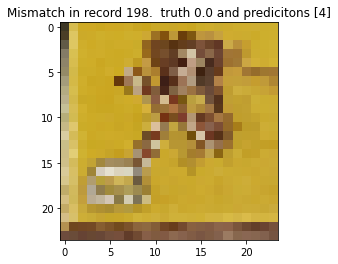

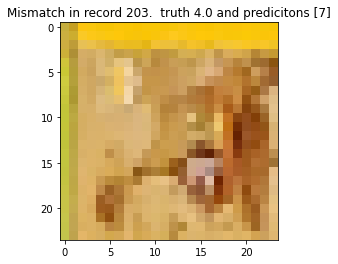

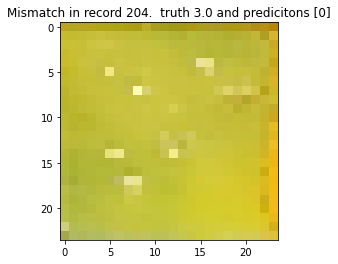

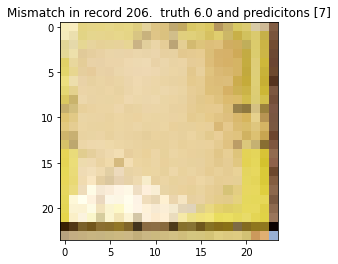

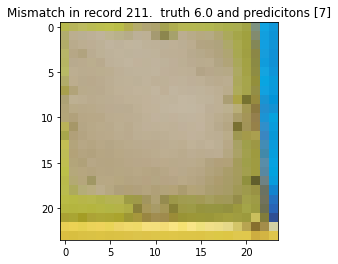

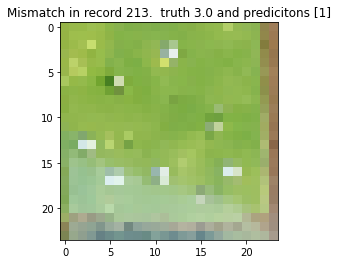

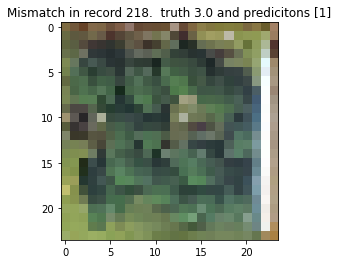

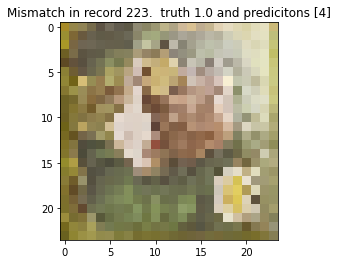

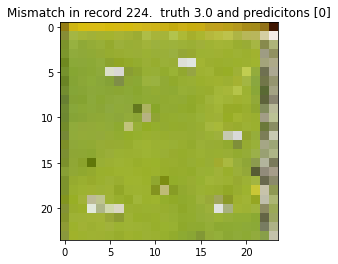

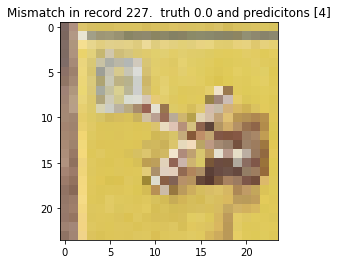

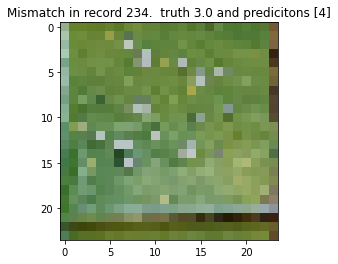

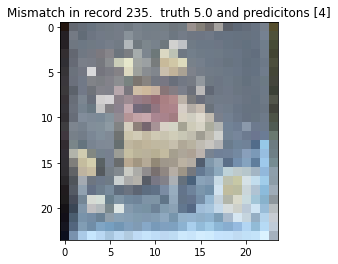

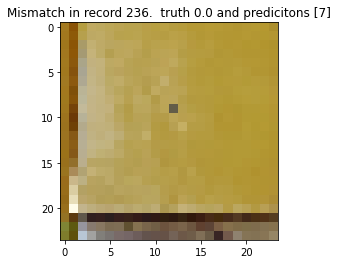

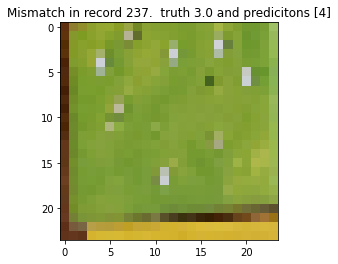

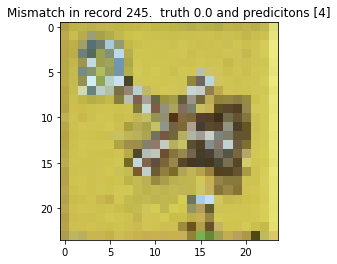

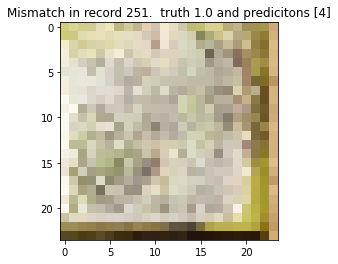

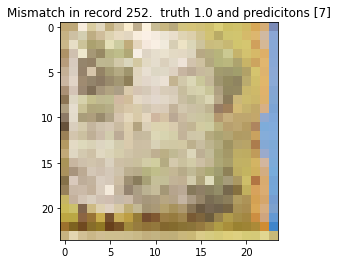

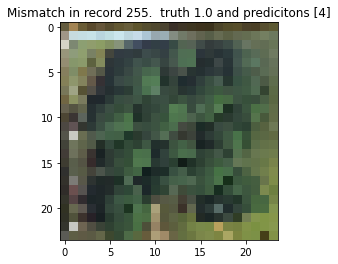

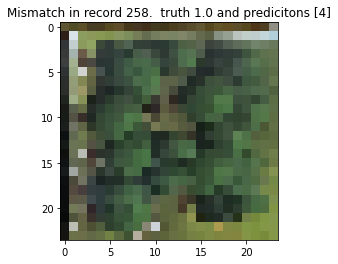

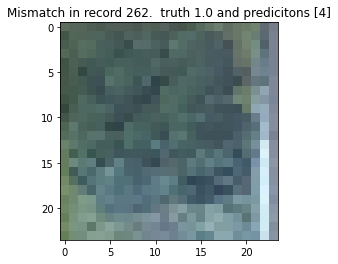

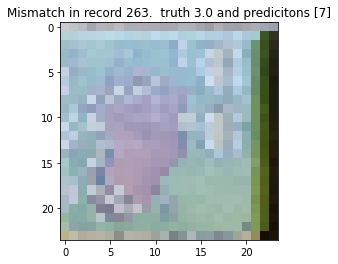

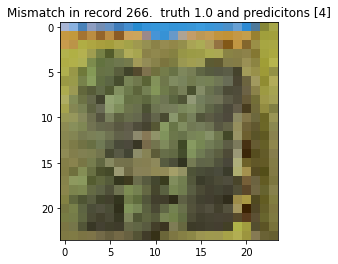

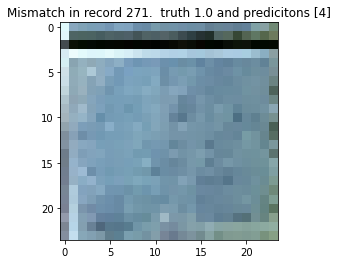

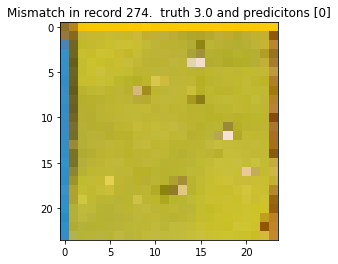

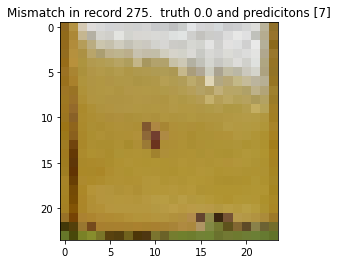

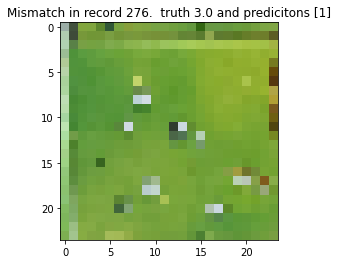

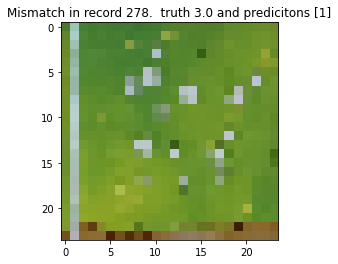

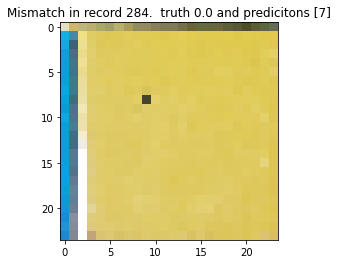

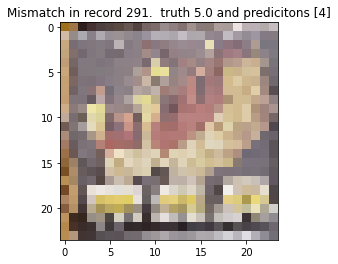

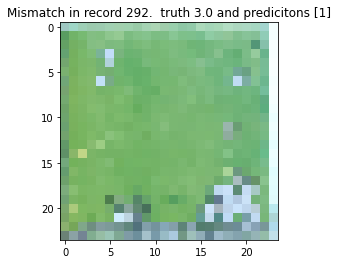

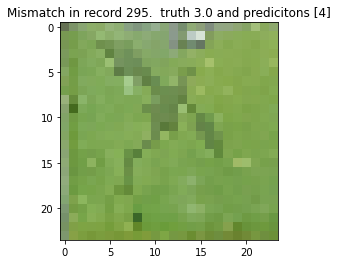

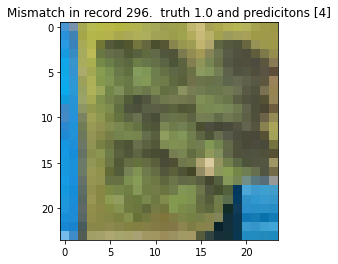

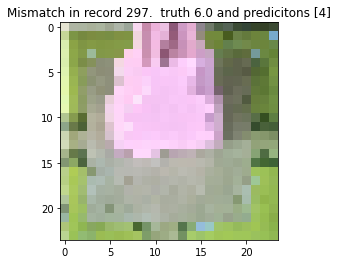

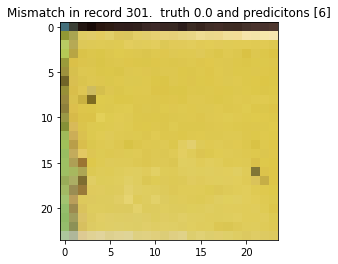

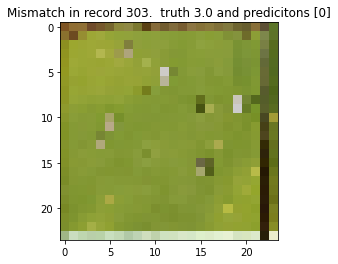

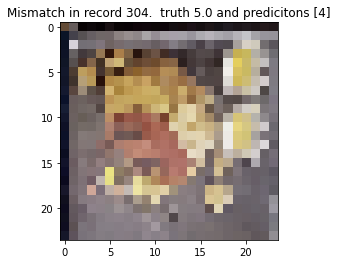

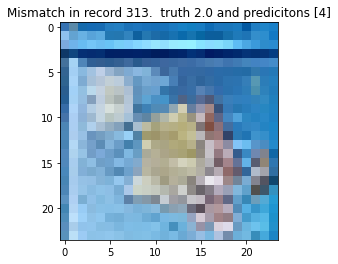

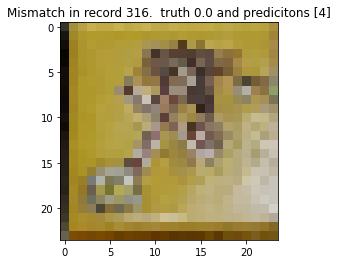

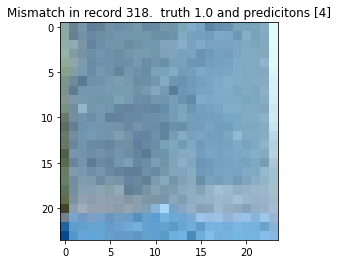

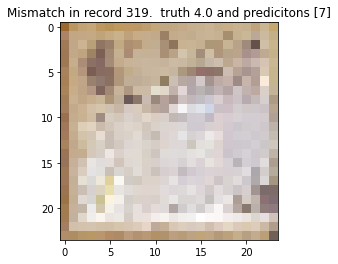

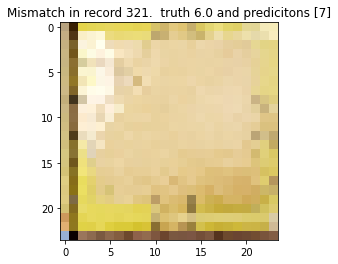

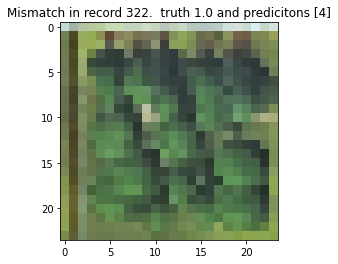

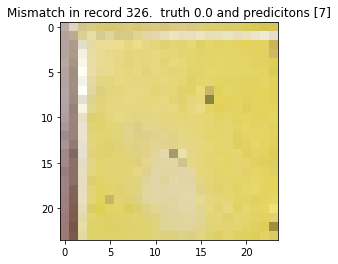

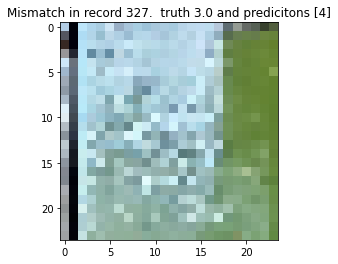

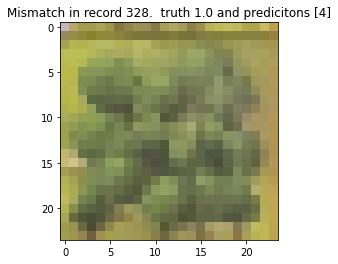

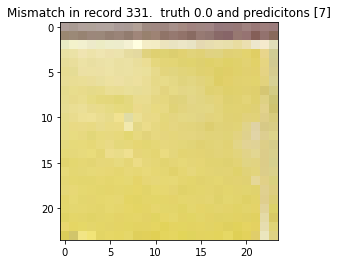

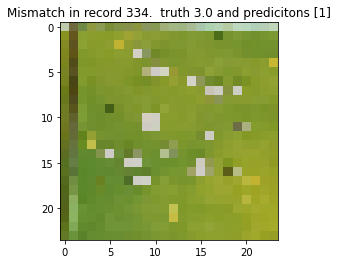

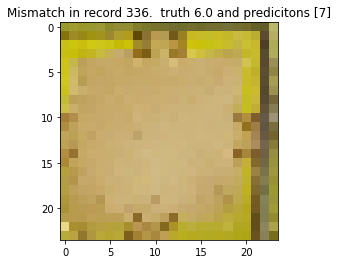

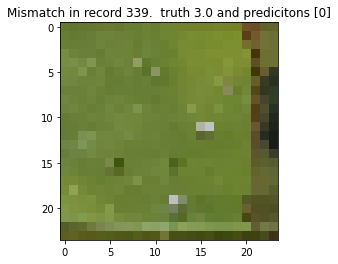

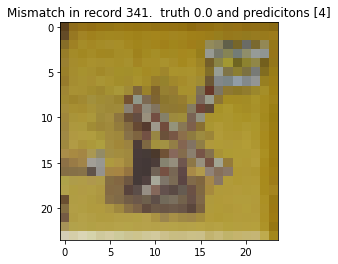

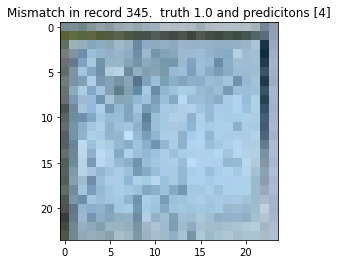

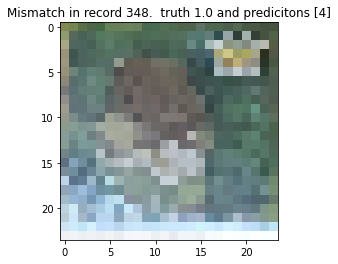

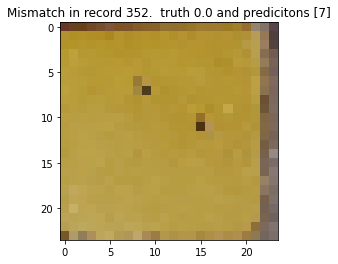

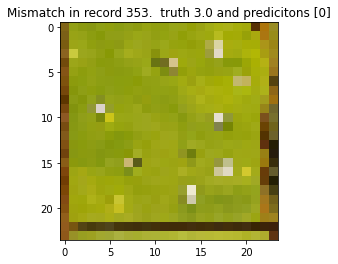

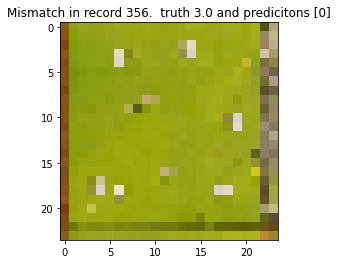

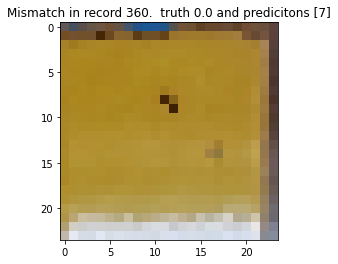

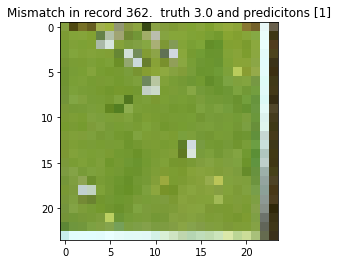

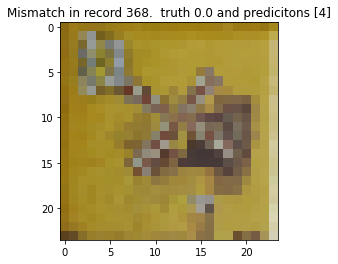

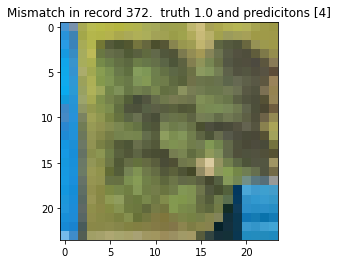

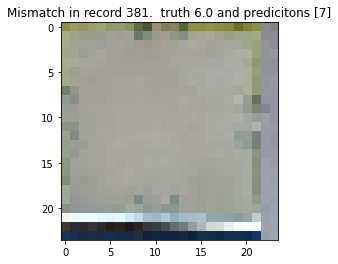

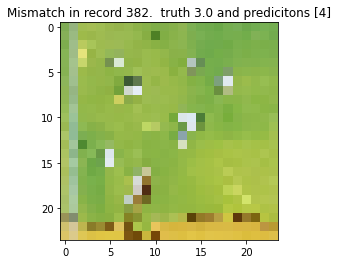

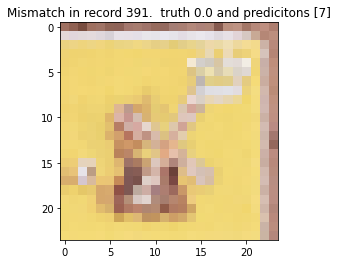

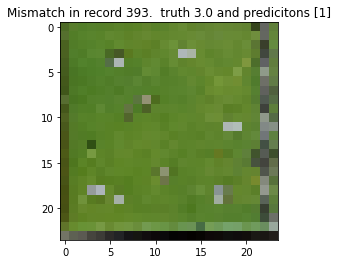

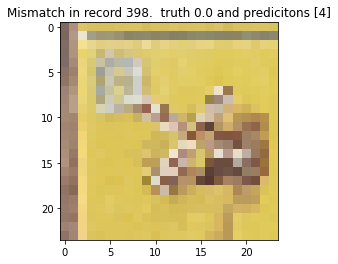

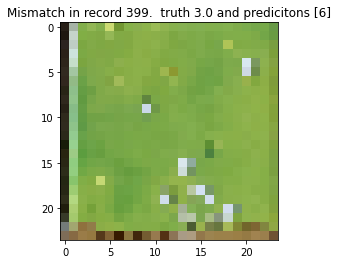

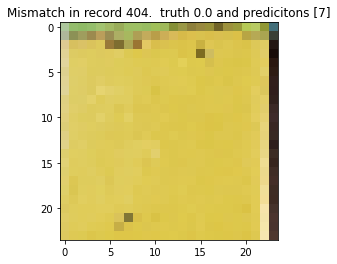

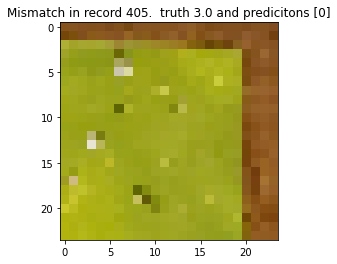

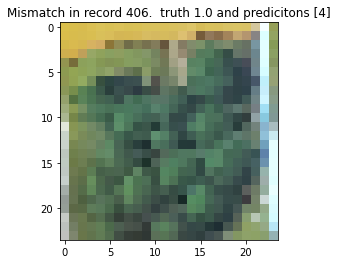

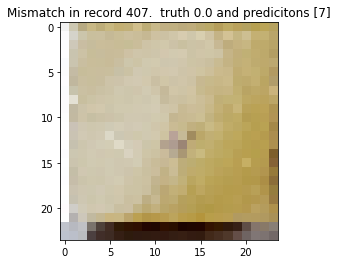

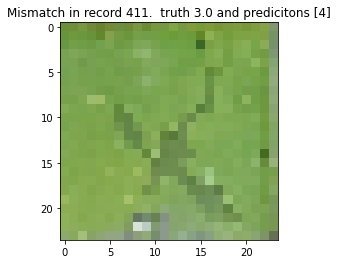

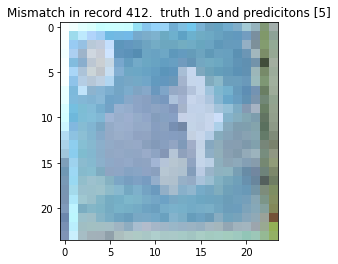

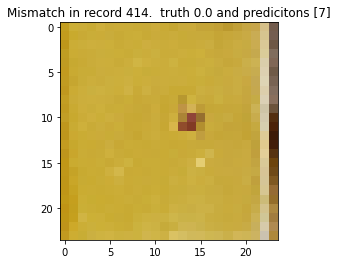

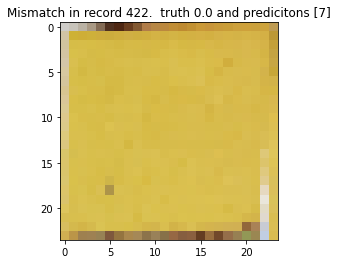

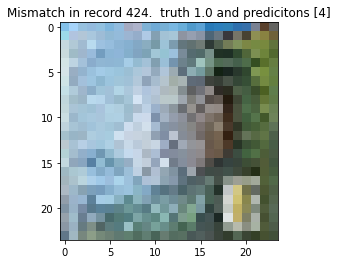

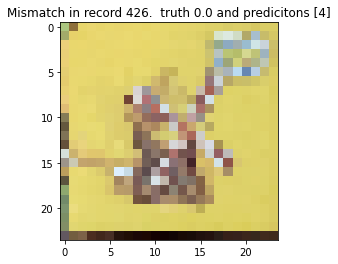

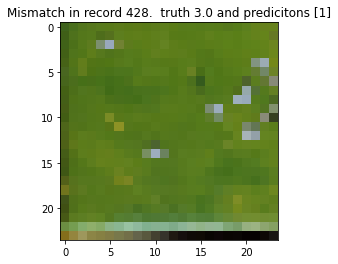

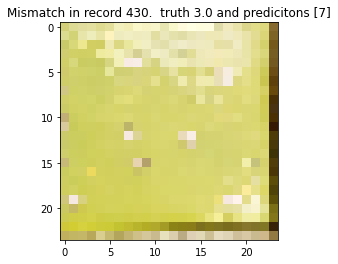

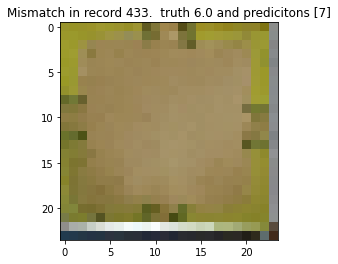

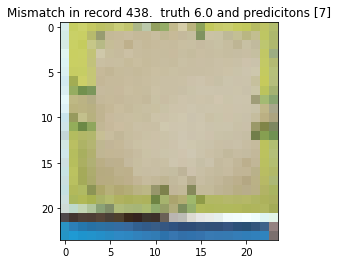

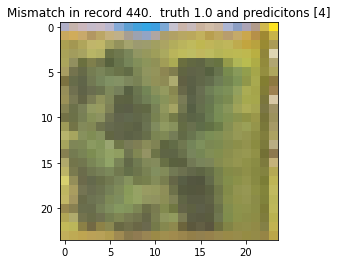

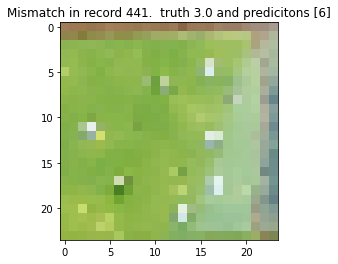

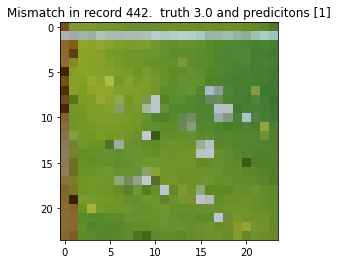

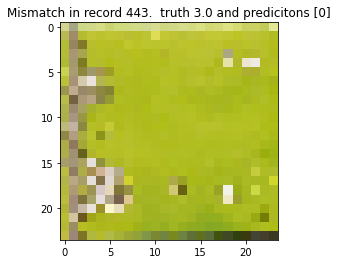

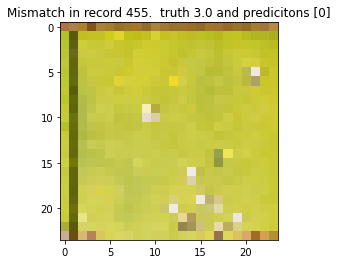

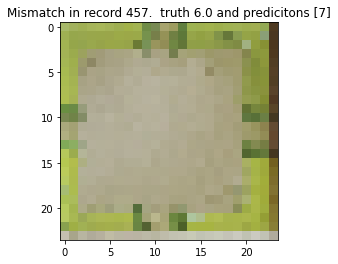

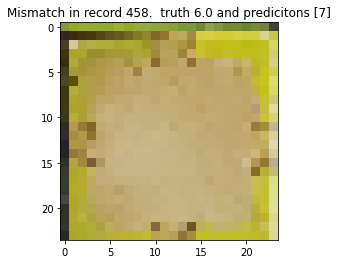

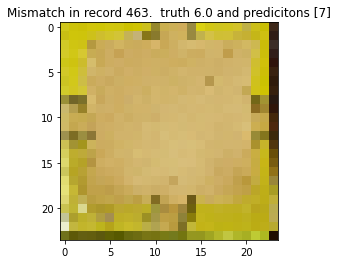

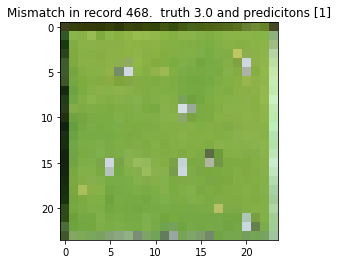

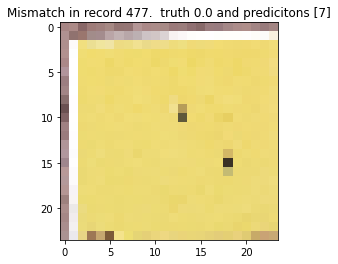

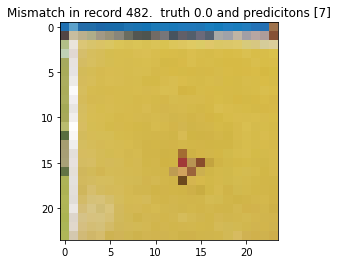

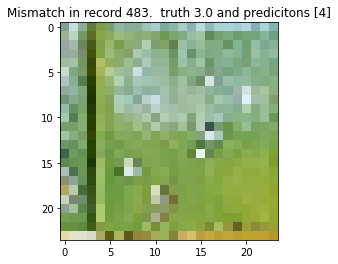

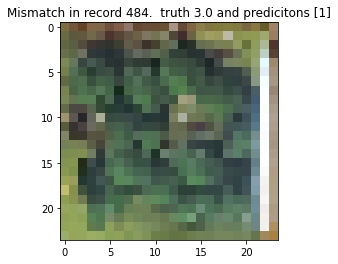

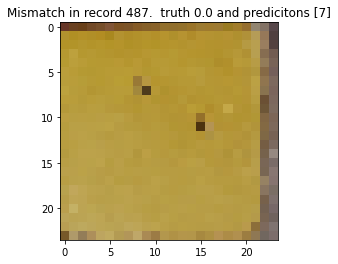

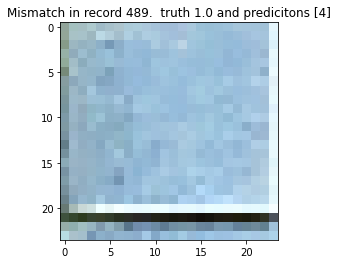

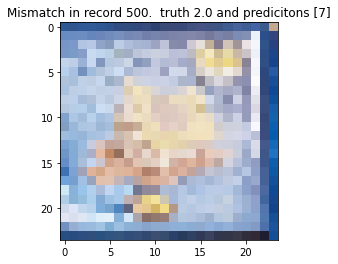

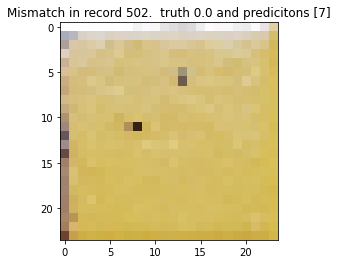

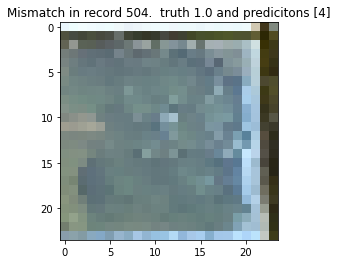

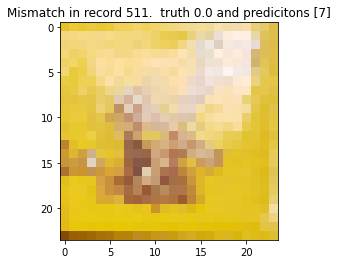

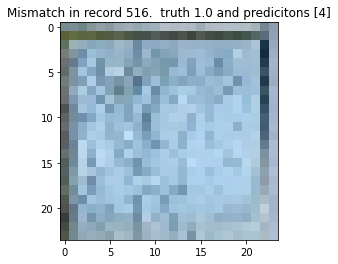

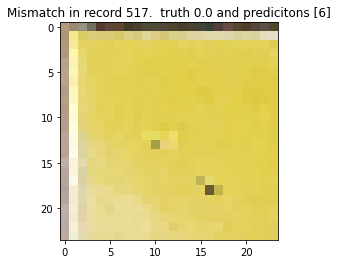

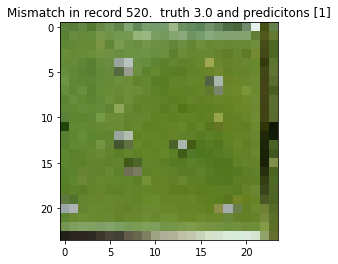

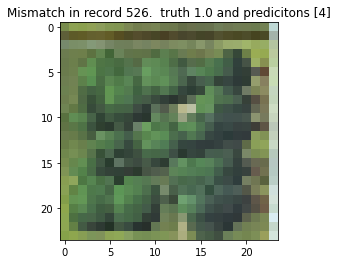

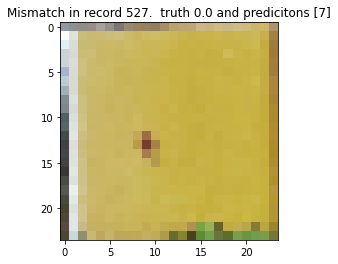

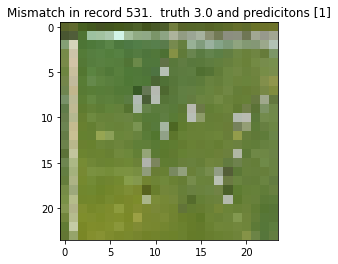

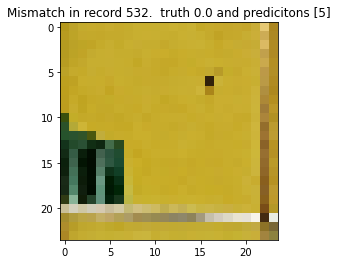

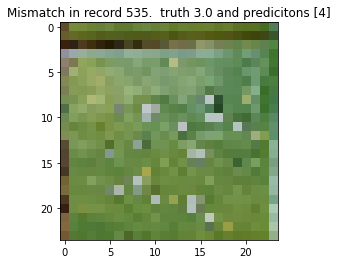

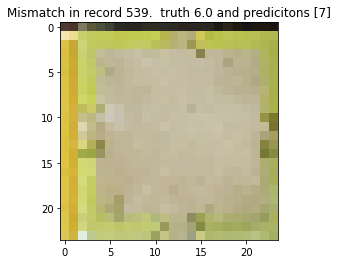

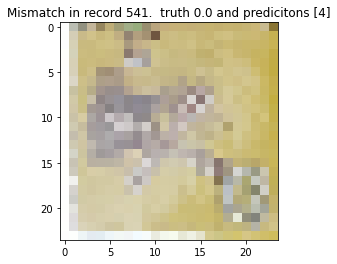

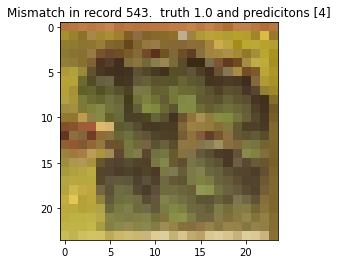

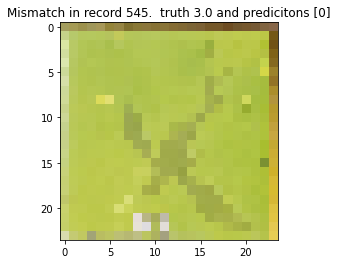

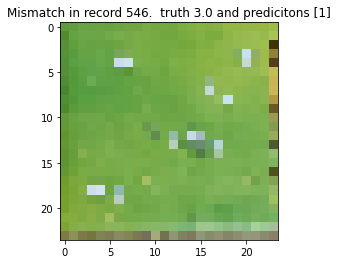

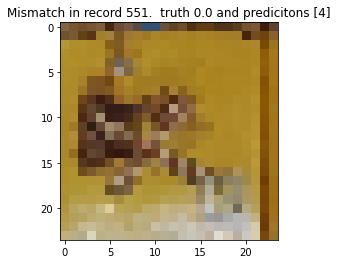

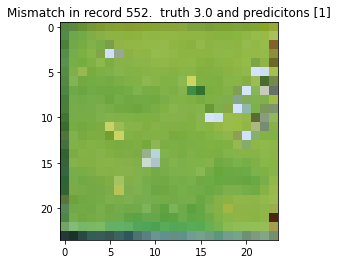

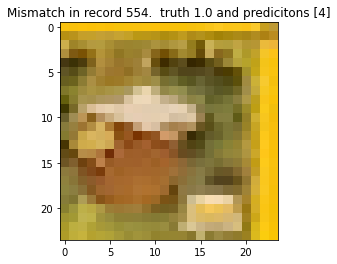

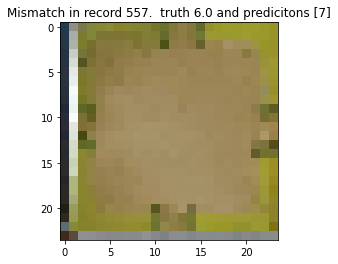

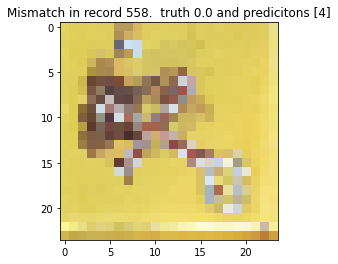

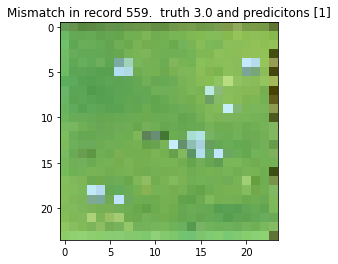

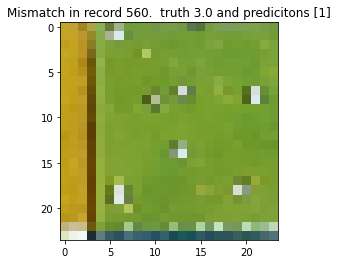

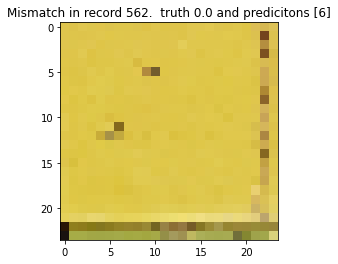

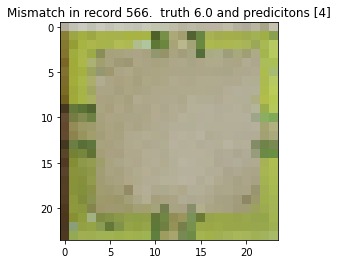

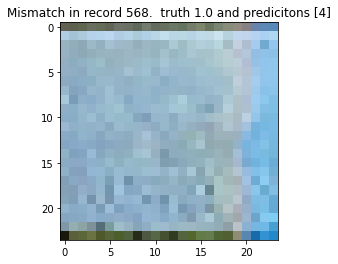

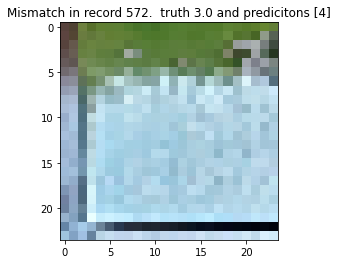

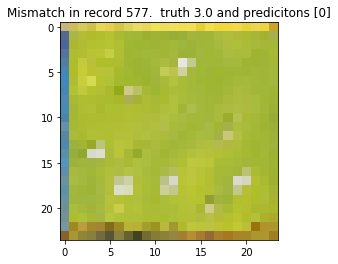

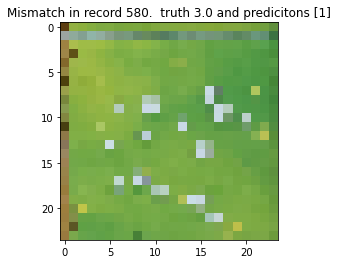

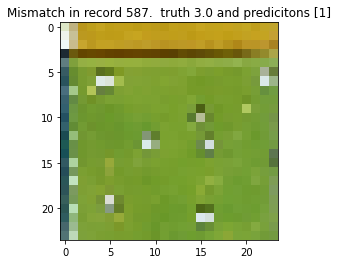

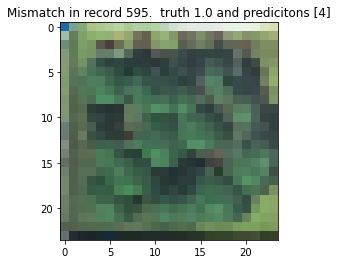

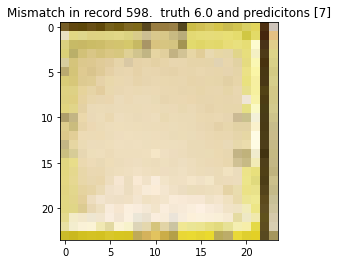

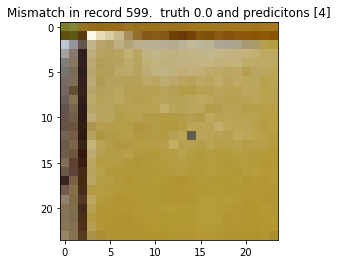

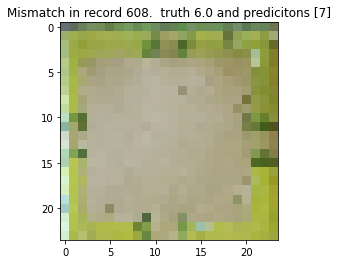

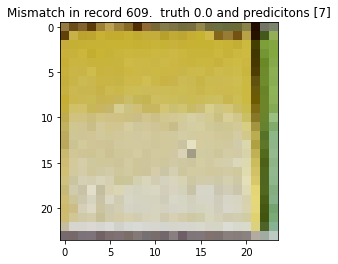

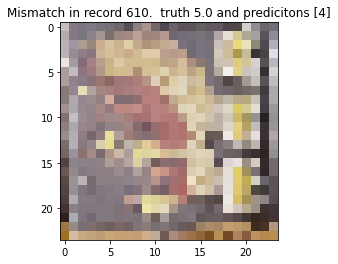

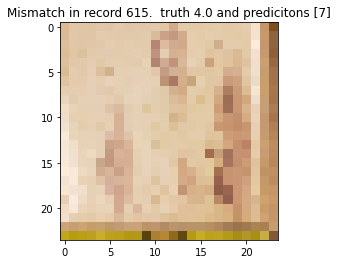

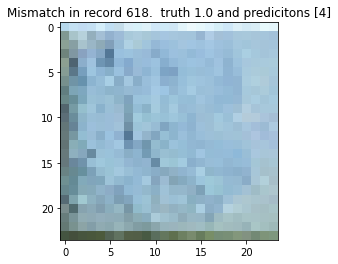

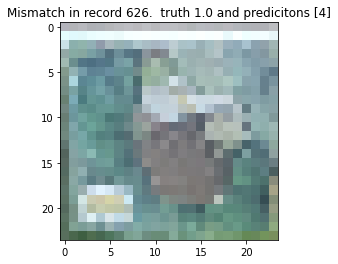

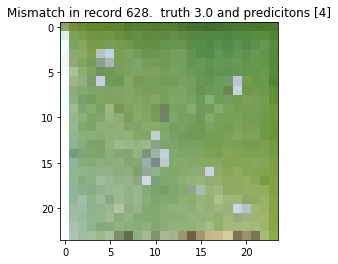

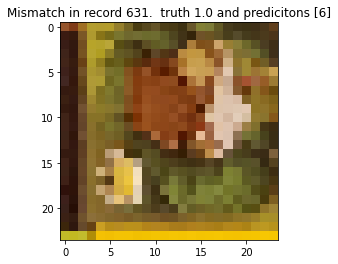

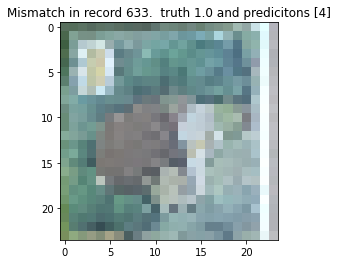

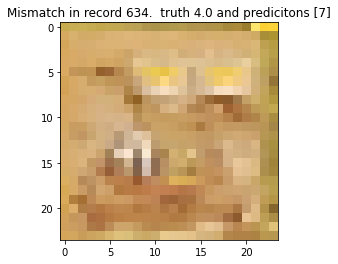

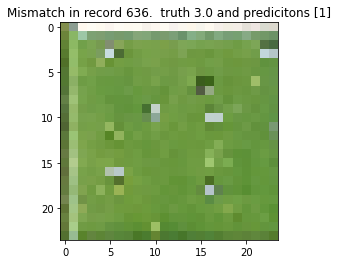

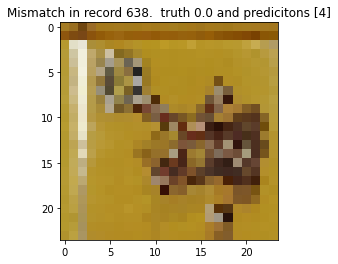

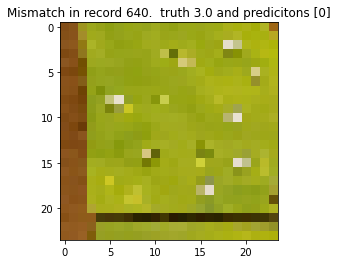

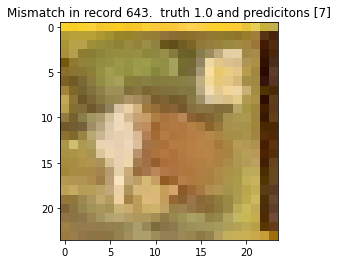

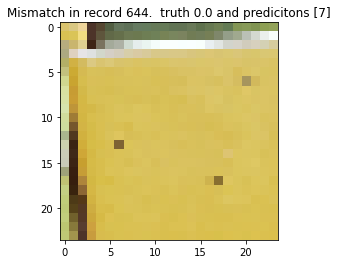

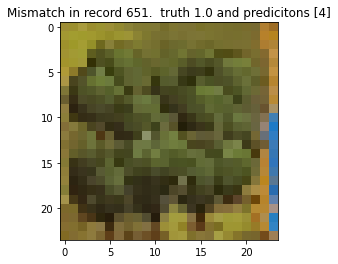

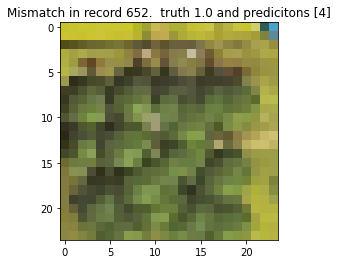

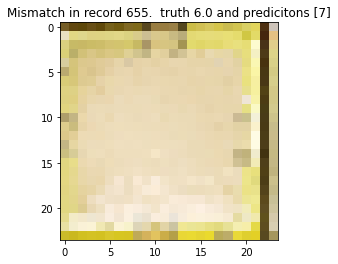

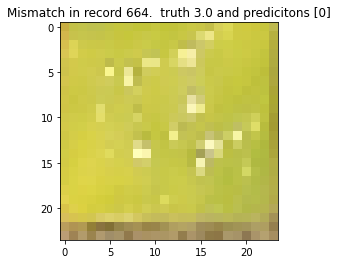

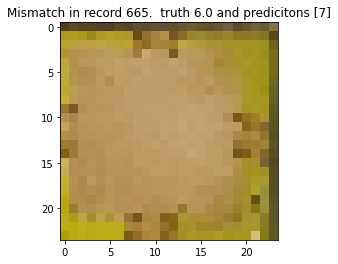

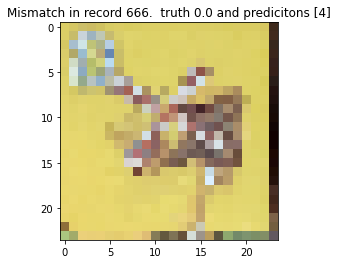

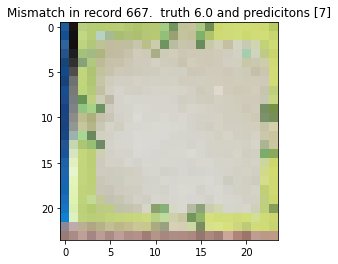

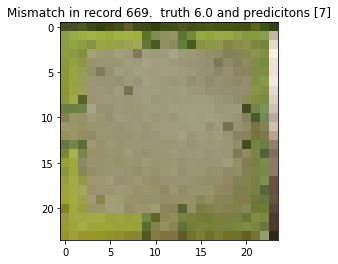

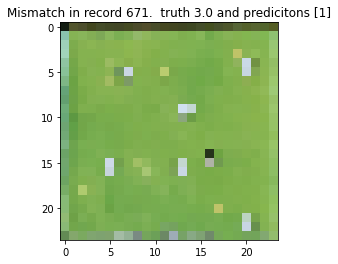

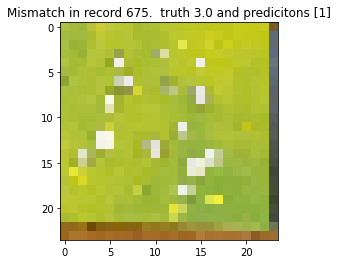

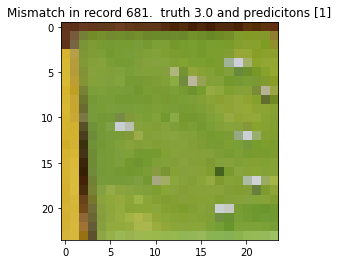

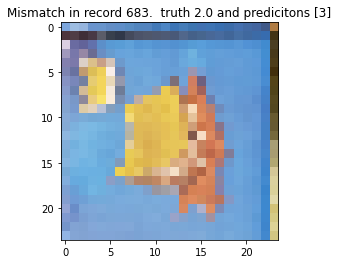

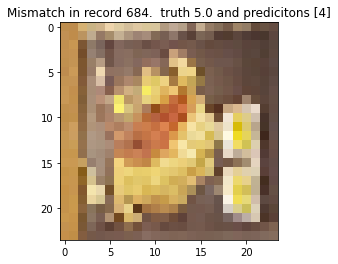

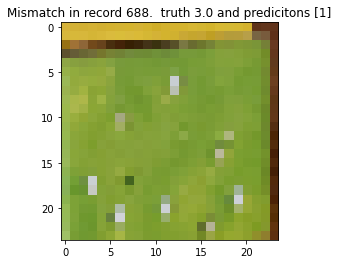

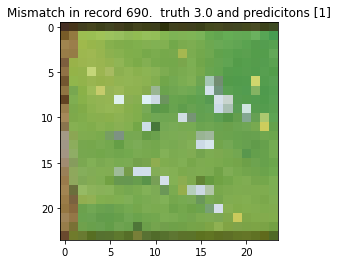

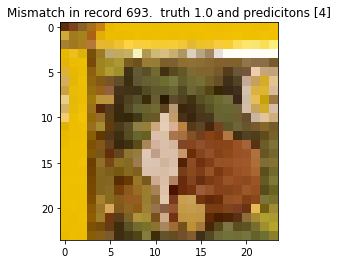

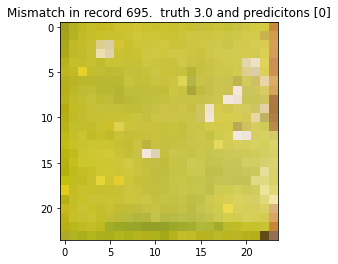

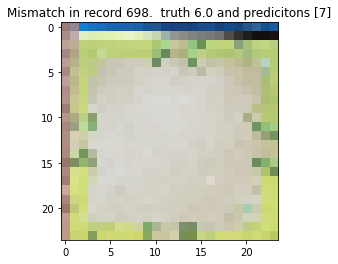

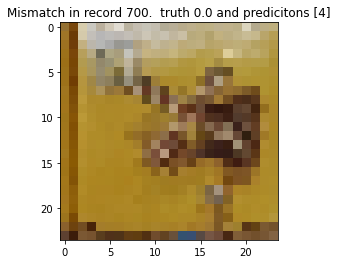

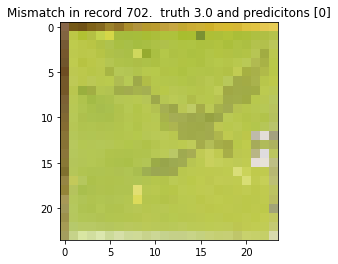

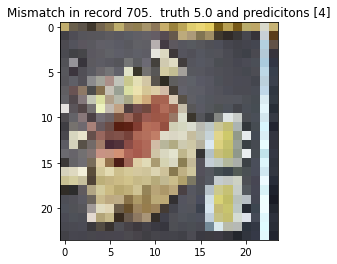

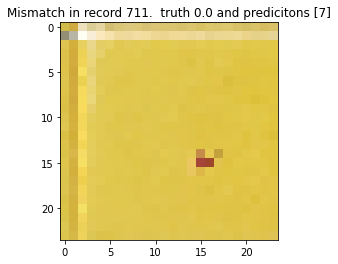

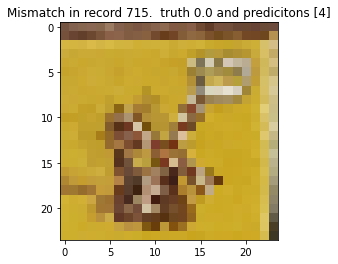

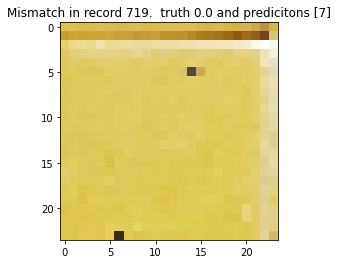

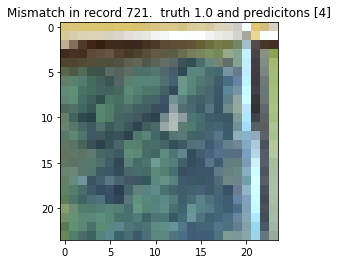

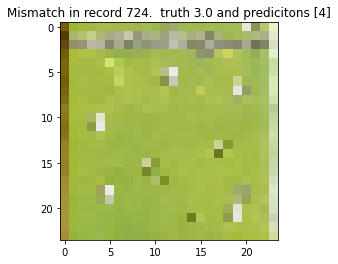

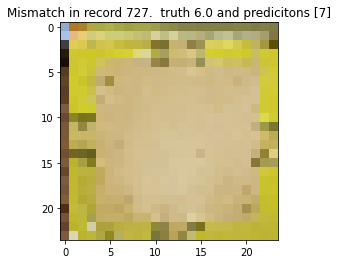

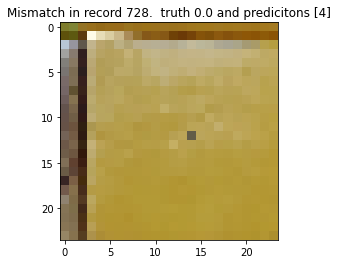

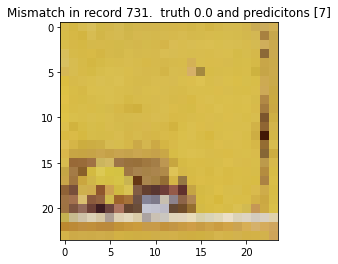

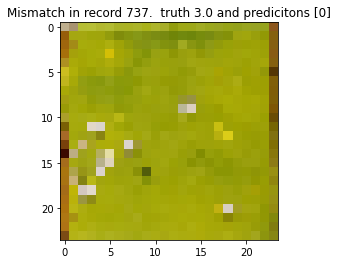

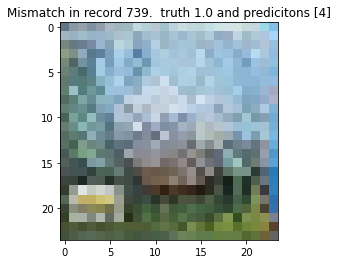

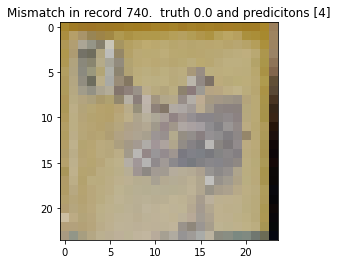

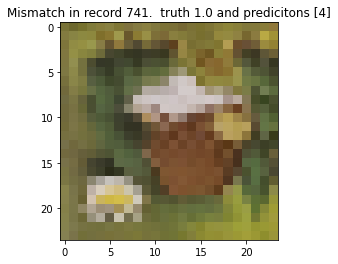

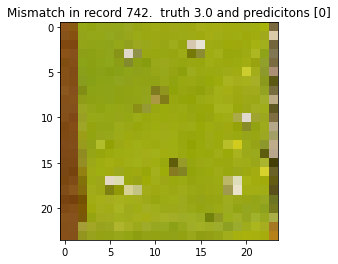

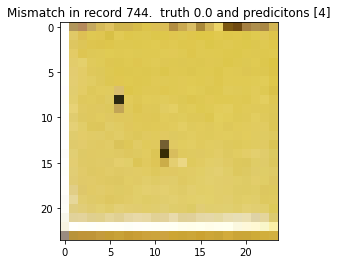

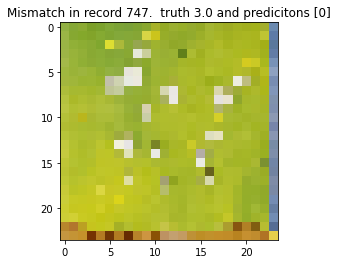

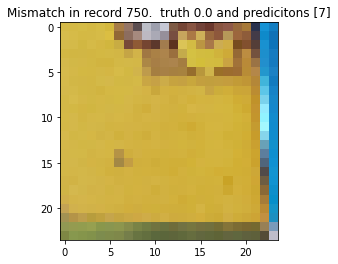

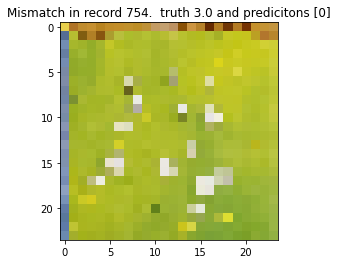

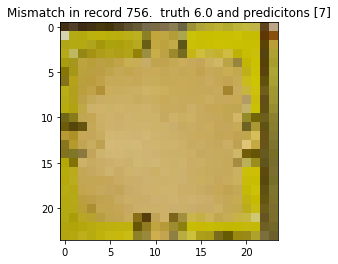

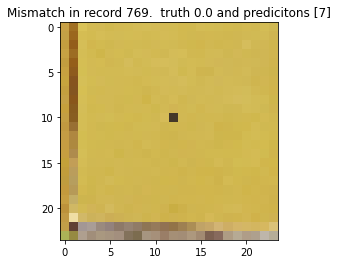

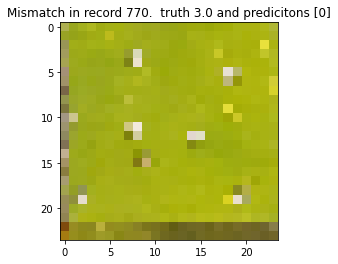

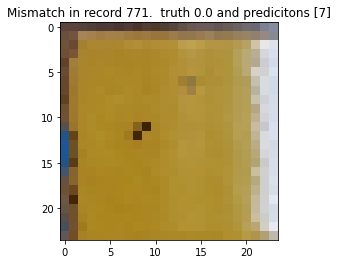

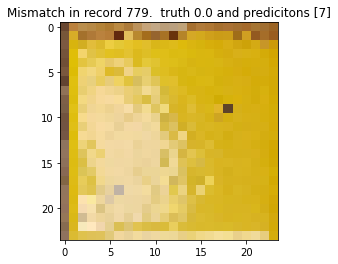

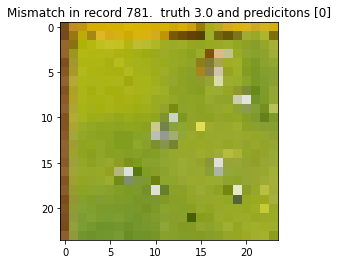

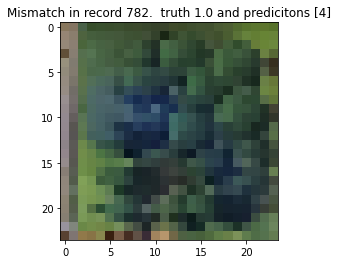

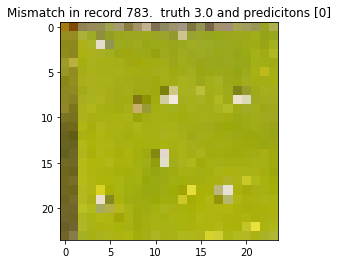

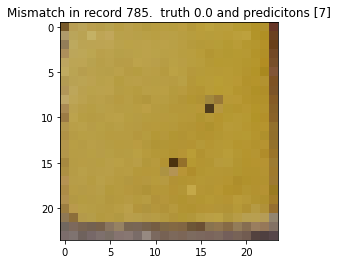

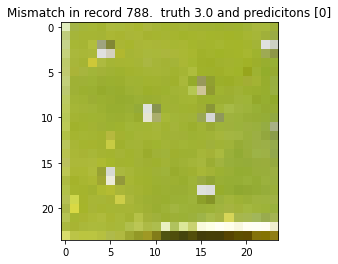

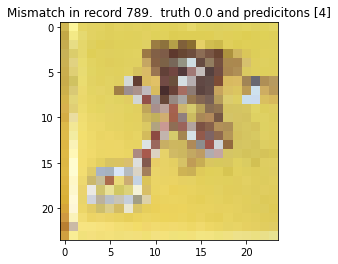

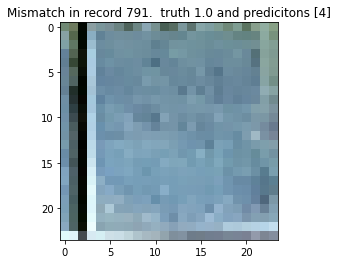

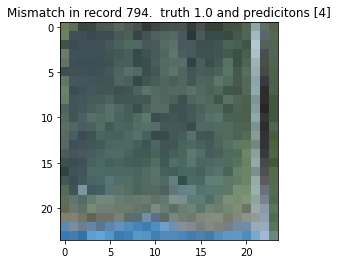

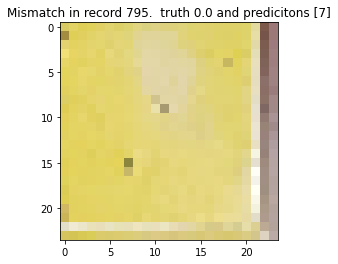

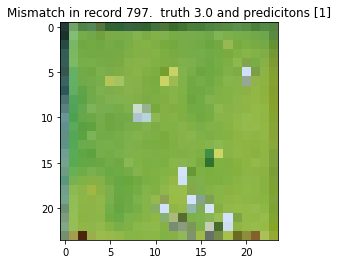

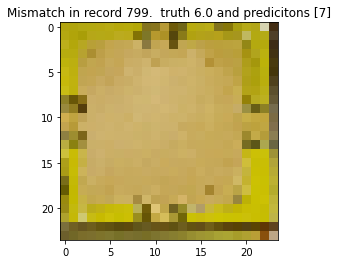

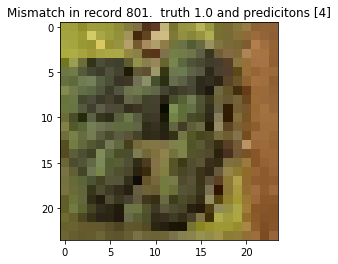

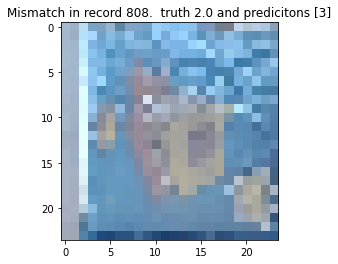

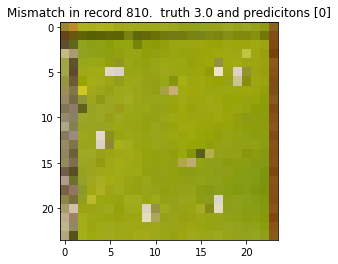

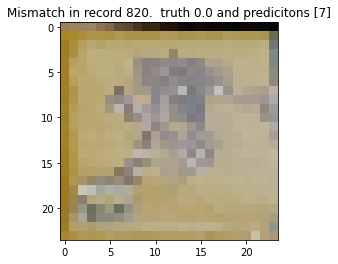

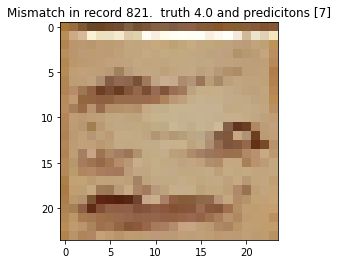

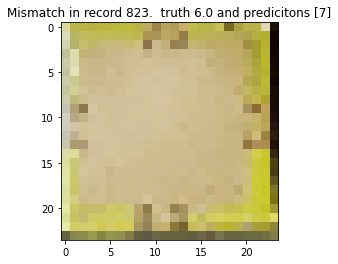

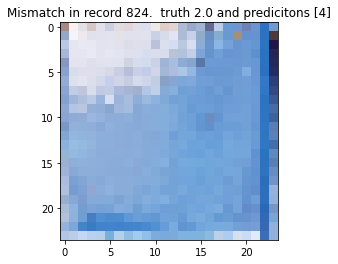

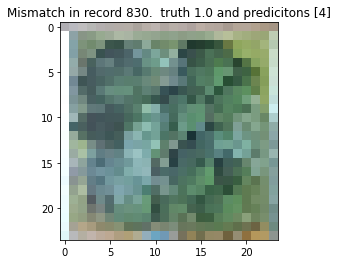

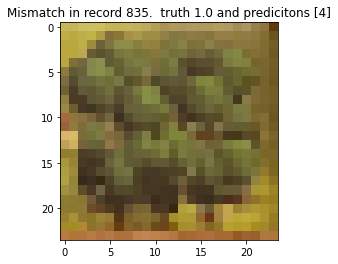

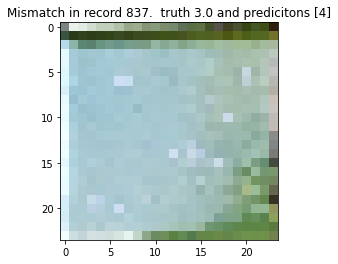

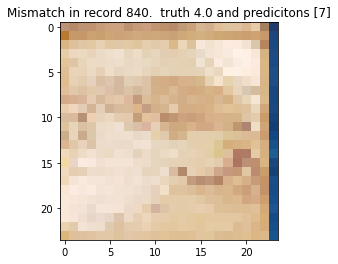

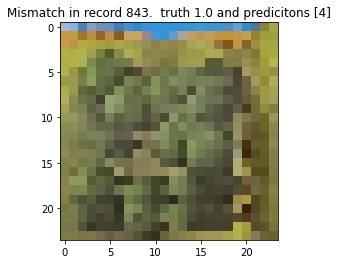

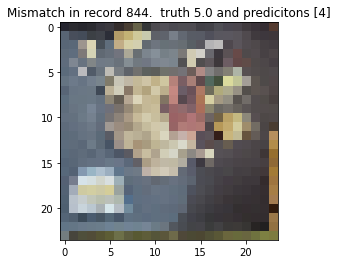

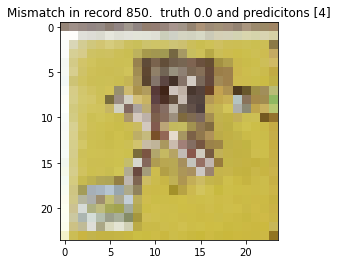

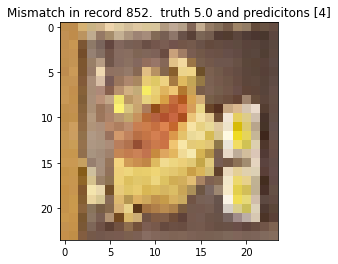

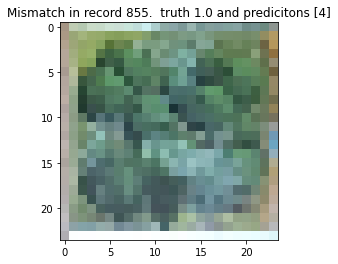

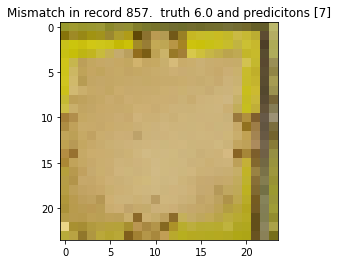

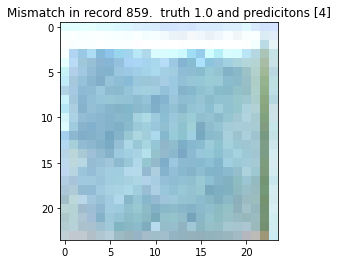

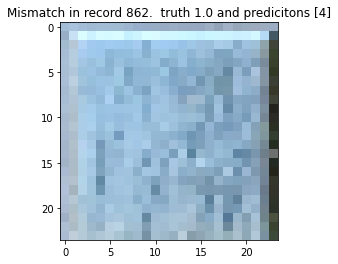

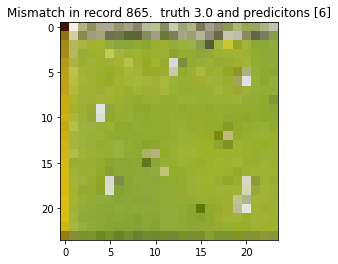

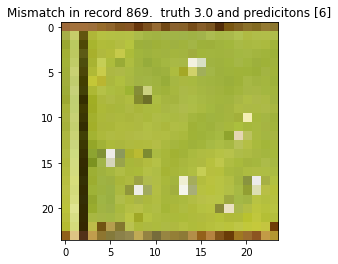

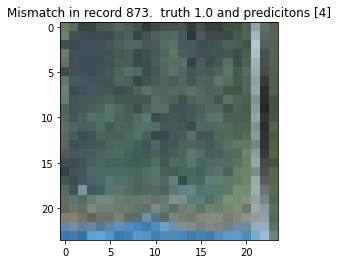

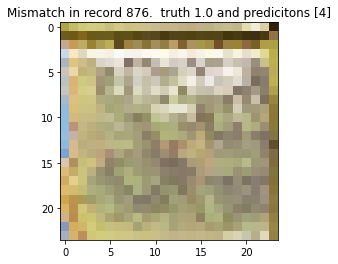

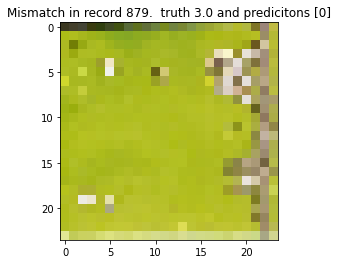

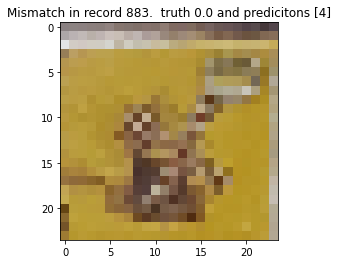

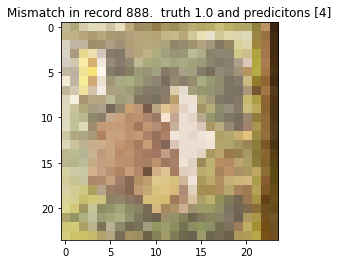

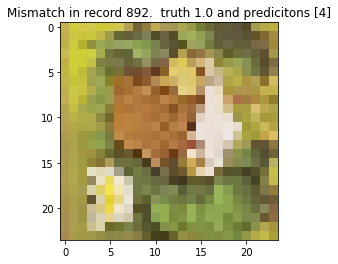

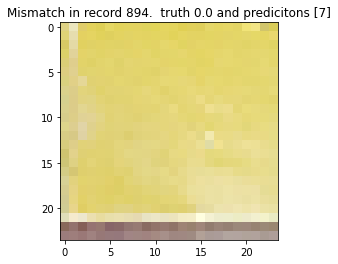

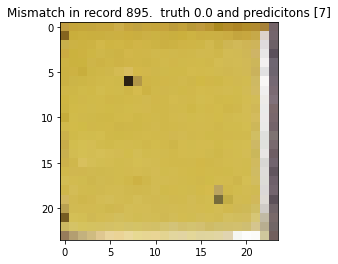

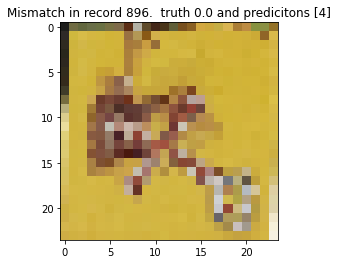

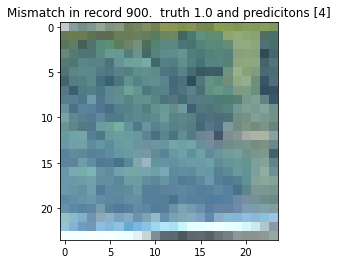

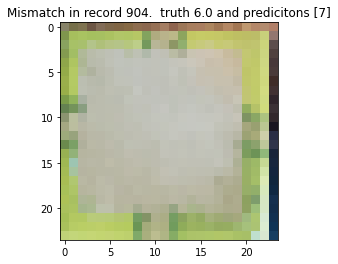

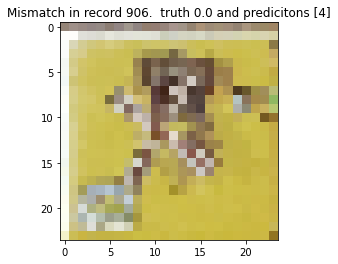

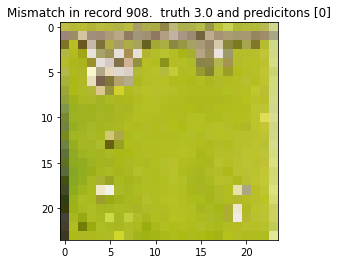

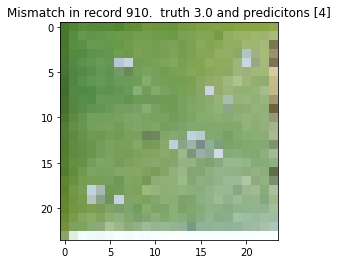

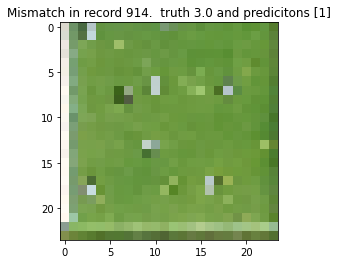

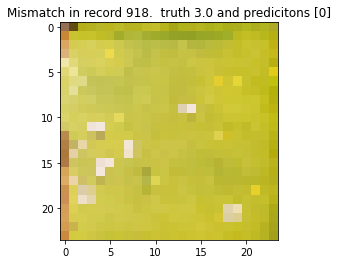

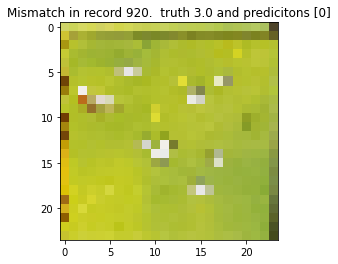

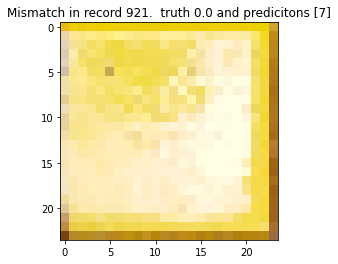

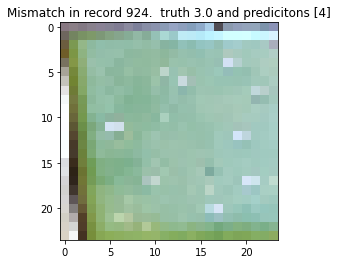

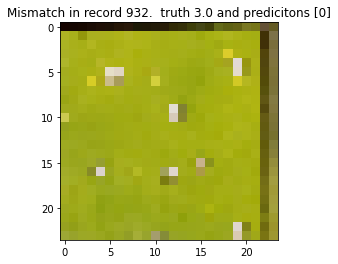

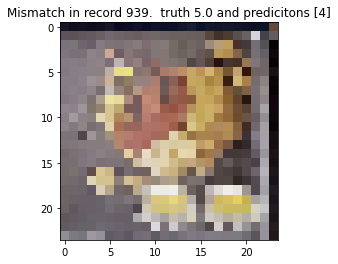

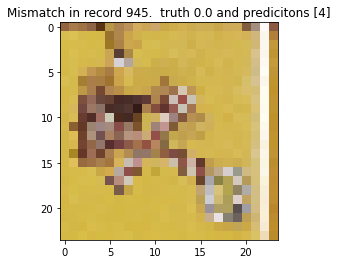

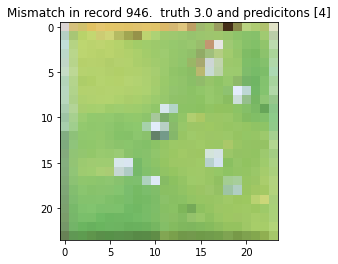

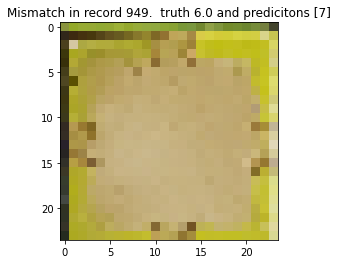

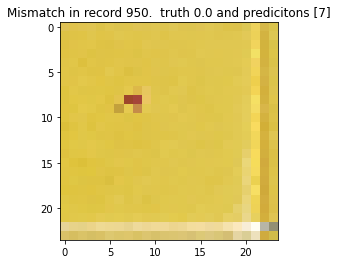

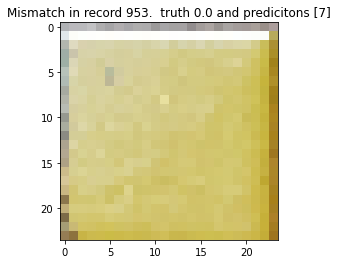

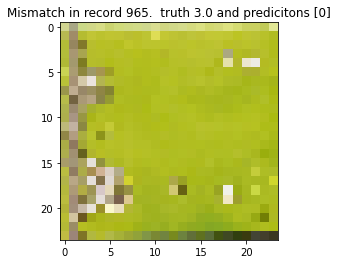

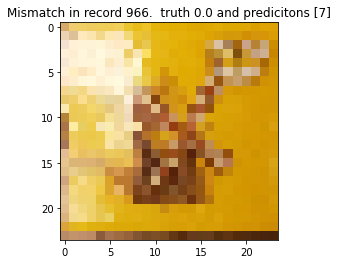

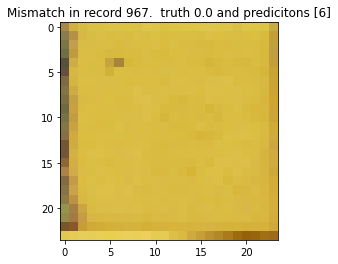

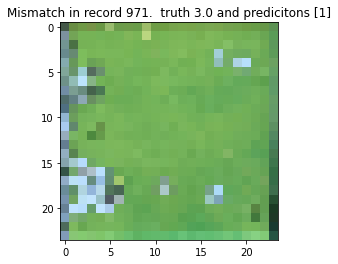

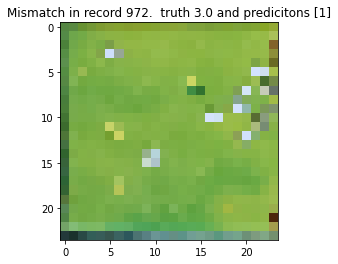

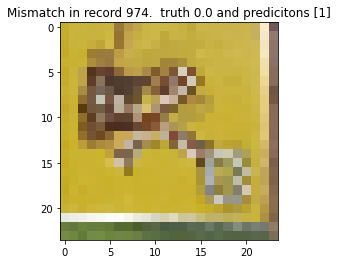

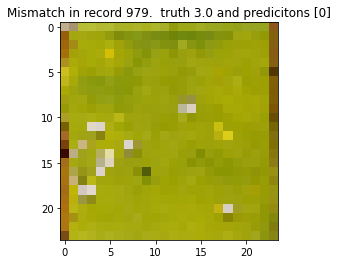

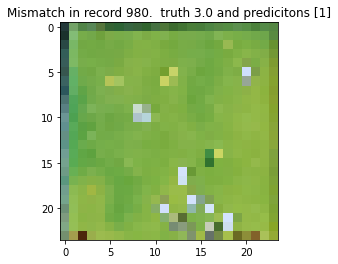

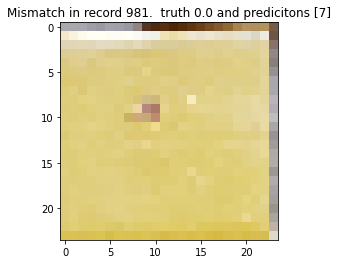

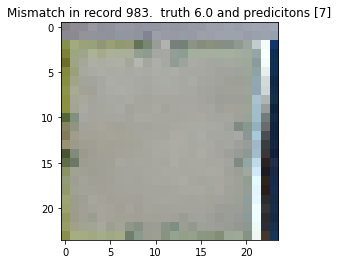

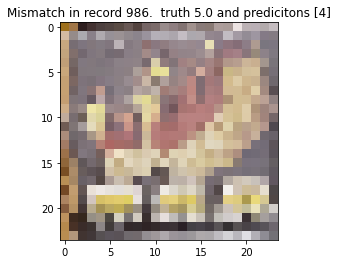

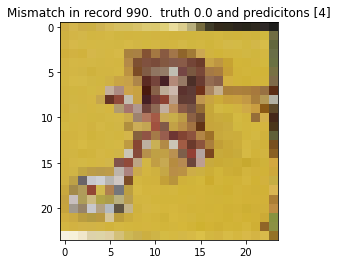

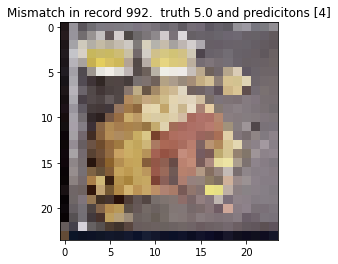

In [10]:
predictions = model_terrain.predict(valid_x)
confusion = np.zeros((8, 8))
for i in range(valid_N):
    which = np.where( predictions[i] == np.max(predictions[i]) )[0]
    confusion[int(valid_terrain_y[i]), int(which)] += 1
    if which != valid_terrain_y[i]:
        plt.figure()
        plt.title("Mismatch in record {0}.  truth {1} and predicitons {2}".format(i, valid_terrain_y[i], which))
        plt.imshow(valid_x[i].astype('uint8'))

In [11]:
confusion

array([[158.,   1.,   0.,   0.,  32.,   1.,   4.,  47.],
       [  0., 123.,   0.,   0.,  60.,   1.,   1.,   3.],
       [  0.,   0., 156.,   3.,   2.,   0.,   0.,   1.],
       [ 44.,  35.,   0.,  61.,  20.,   0.,   6.,   2.],
       [  0.,   0.,   0.,   0., 121.,   0.,   0.,   7.],
       [  0.,   0.,   0.,   0.,  12.,  37.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   2.,   0.,   5.,  30.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.]])

array([[7.7849341e-05, 1.1146273e-05, 1.7765379e-07, 5.5841232e-05,
        1.5861740e-02, 1.4839596e-05, 1.9133970e-02, 9.6484452e-01]],
      dtype=float32)

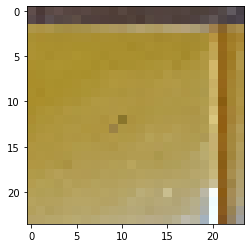

In [12]:
import matplotlib.pyplot as plt

plt.imshow(training_x[525].astype('uint8'))
model_terrain.predict(training_x[525:526])

In [13]:
model_terrain.save("models/terrain_model.keras")

In [25]:
print("Fit model on training data")
history = model_crowns.fit(
    training_x,
    crowns_y,
    batch_size=64,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(valid_x, valid_crowns_y),
)

Fit model on training data
Epoch 1/20
70/70 [==============================] - 1s 10ms/step - loss: 0.8658 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.4442 - val_sparse_categorical_accuracy: 0.8460
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 0.5970 - sparse_categorical_accuracy: 0.8047 - val_loss: 0.3554 - val_sparse_categorical_accuracy: 0.8830
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.8208 - val_loss: 0.3929 - val_sparse_categorical_accuracy: 0.8730
Epoch 4/20
70/70 [==============================] - 1s 9ms/step - loss: 0.4750 - sparse_categorical_accuracy: 0.8425 - val_loss: 0.3129 - val_sparse_categorical_accuracy: 0.8950
Epoch 5/20
70/70 [==============================] - 1s 9ms/step - loss: 0.4337 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.3397 - val_sparse_categorical_accuracy: 0.8840
Epoch 6/20
70/70 [==============================] - 1s 8ms/step - loss: 0.4034 - s

In [26]:
valid_crowns_y.shape

(1000,)

<ipython-input-27-363ea7994513>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


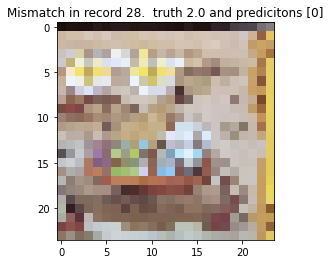

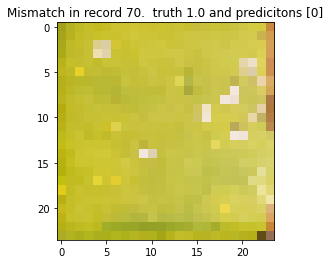

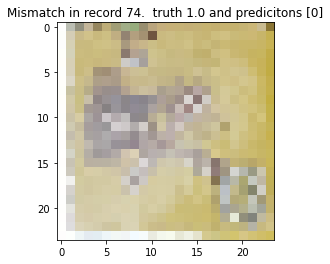

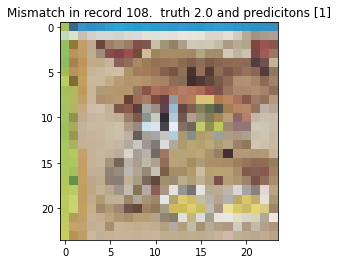

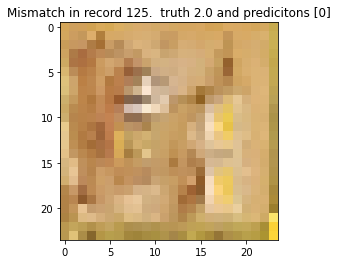

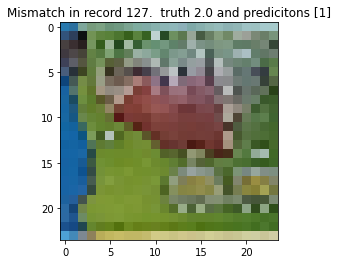

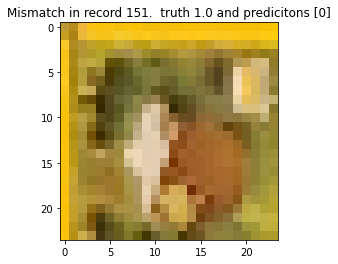

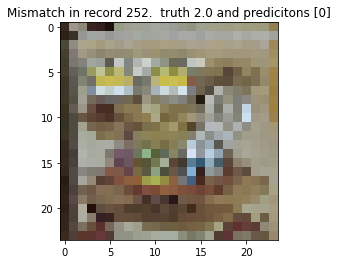

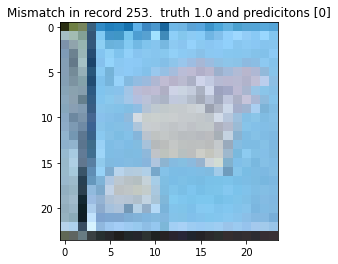

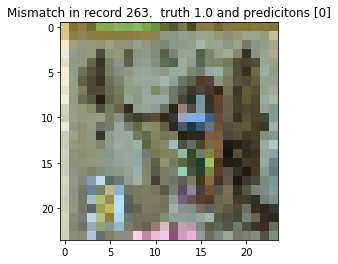

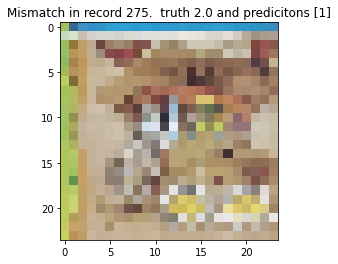

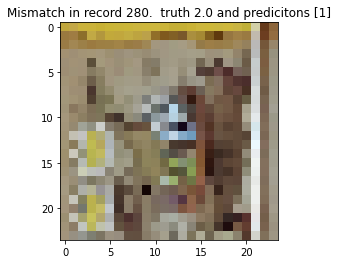

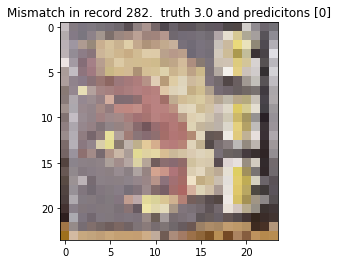

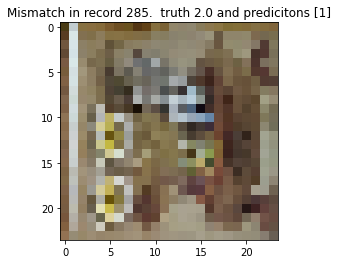

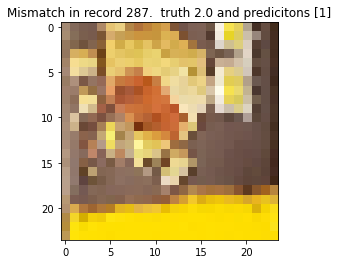

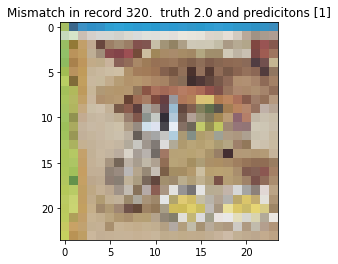

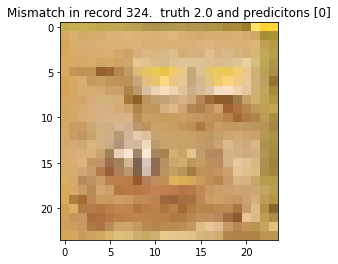

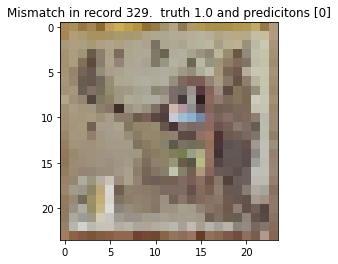

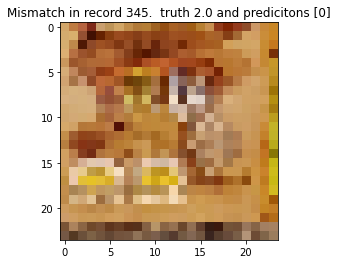

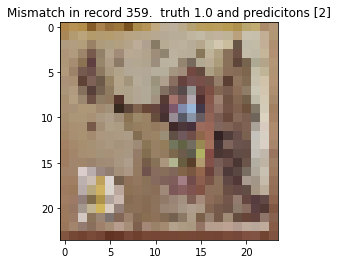

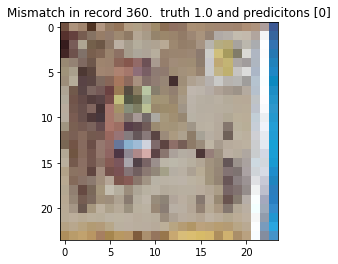

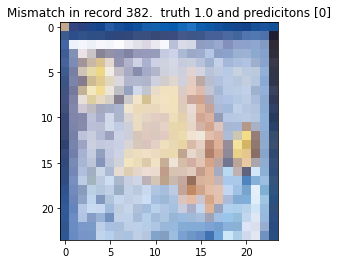

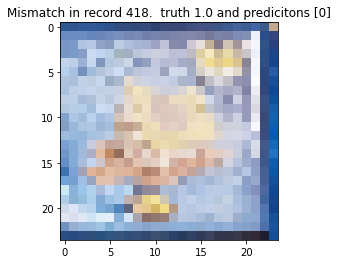

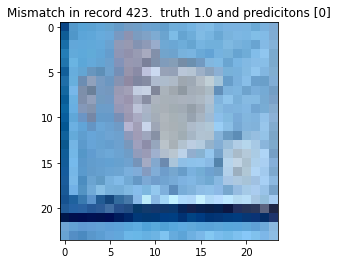

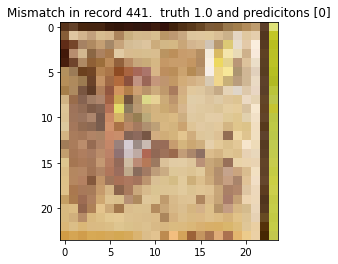

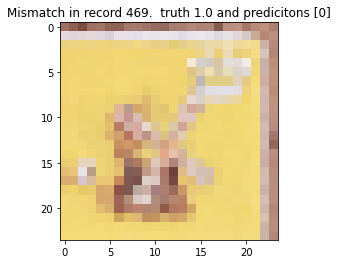

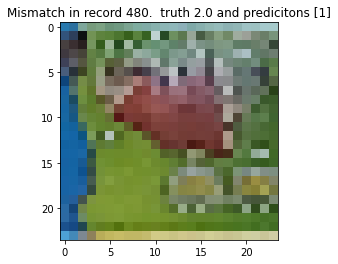

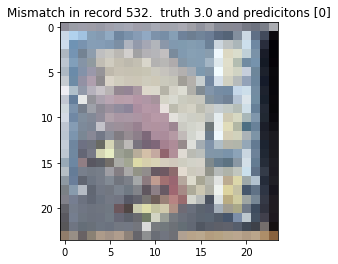

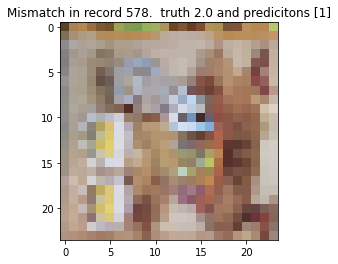

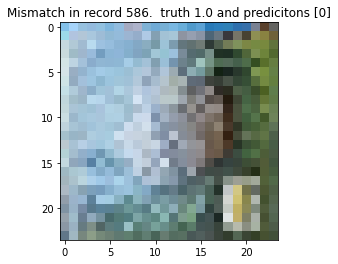

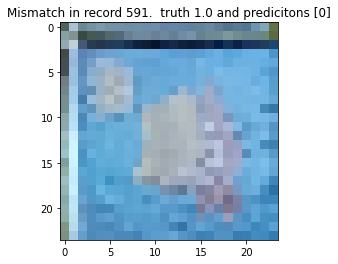

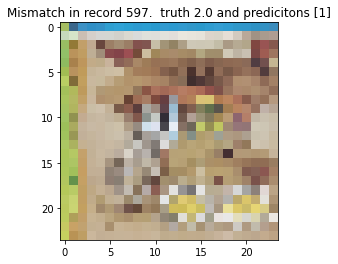

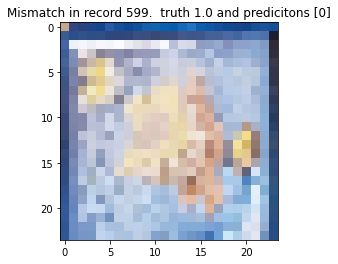

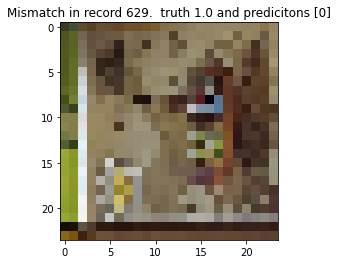

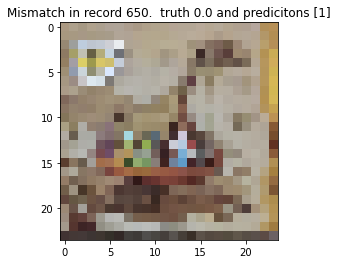

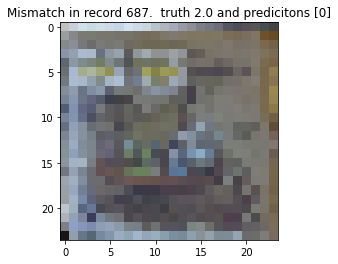

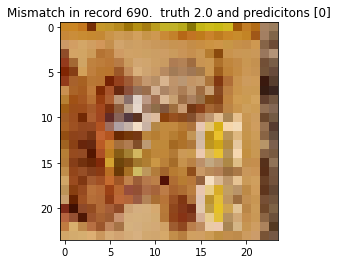

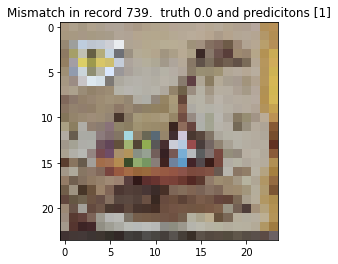

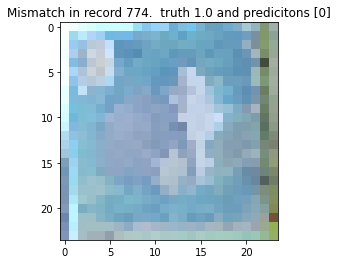

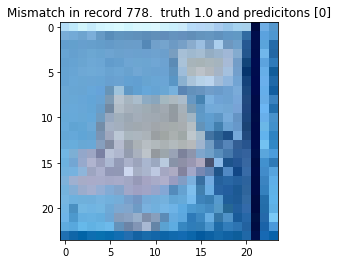

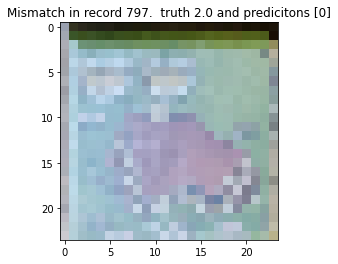

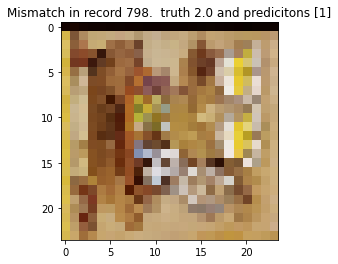

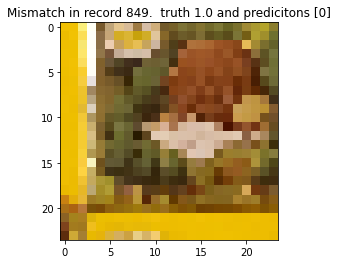

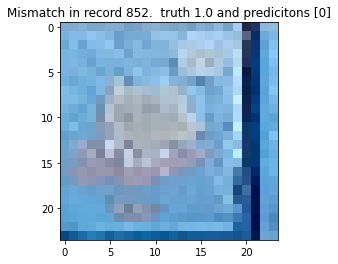

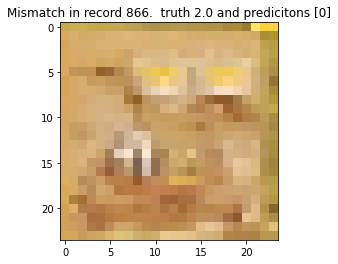

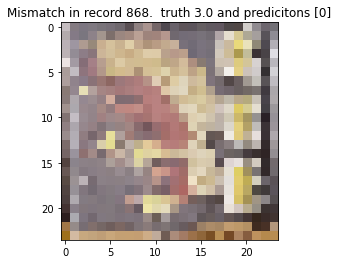

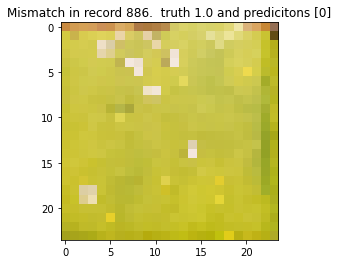

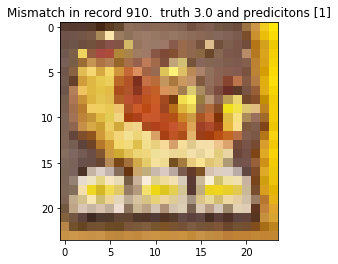

In [27]:
predictions = model_crowns.predict(valid_x)
confusion = np.zeros((4, 4))
for i in range(valid_N):
    which = np.where( predictions[i] == np.max(predictions[i]) )[0]
    confusion[int(valid_crowns_y[i]), int(which)] += 1
    if which != valid_crowns_y[i]:
        plt.figure()
        plt.title("Mismatch in record {0}.  truth {1} and predicitons {2}".format(i, valid_crowns_y[i], which))
        plt.imshow(valid_x[i].astype('uint8'))

In [28]:
confusion

array([[699.,   2.,   0.,   0.],
       [ 21., 186.,   1.,   0.],
       [  9.,  11.,  60.,   0.],
       [  3.,   1.,   0.,   7.]])

In [29]:
model_crowns.save("models/crowns_model.keras")